### Combo screen PacBio barcode fidelity analysis

This script generates various barcode fidelity plots beginning from PacBio fastqs along with barcode and construct references.

The 'pacbio_comboscreen_bc_and_construct_assignments.csv' file available on [Zenodo](https://zenodo.org/records/17594332) contains the barcode and construct assignments following alignment with minimap2.

Please contact hartmana@stanford.edu if interested in additional upstream data.

In [ ]:
import os
import time
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import itables
from itables import init_notebook_mode, show

from Bio import SeqIO
from Bio.Seq import Seq
import pysam

from ahocorasick import Automaton
import Levenshtein

In [ ]:
### files
base_path = "../pacbio_data/"

# CSVs
kd_barcodes_csv = f"{base_path}/kd_barcodes.csv"
kd_constructs_csv = f"{base_path}/kd_combo.csv"
ko_barcodes_csv = f"{base_path}/ko_barcodes.csv"
ko_constructs_csv = f"{base_path}/ko_combo.csv"
overexp_barcodes_csv = f"{base_path}/overexp_barcodes.csv"
overexp_constructs_csv = f"{base_path}/overexp_combo.csv"
signaling_barcodes_csv = f"{base_path}/signaling_barcodes.csv"
signaling_constructs_csv = f"{base_path}/signaling_combo.csv"

# FASTQ
fastq = f"{base_path}/fastq_files/m84127_250131_231902_s2.hifi_reads.bc2009.fastq.gz"

# Output CSVs
barcode_assignment_csv = f"{base_path}/results/pLIB262/pLIB262_barcode_assignments.csv"
construct_assignment_csv = f"{base_path}/results/pLIB262/pLIB262_construct_assignments.csv"

# Constructs sorted BAM
kd_final_bam = f"{base_path}/results/bc2009_kd_minimap.sorted.bam"
ko_final_bam = f"{base_path}/results/bc2009_ko_minimap.sorted.bam"
overexp_final_bam = f"{base_path}/results/bc2009_overexp_minimap.sorted.bam"
signaling_final_bam = f"{base_path}/results/bc2009_signaling_minimap.sorted.bam"

## export necessary variables for bash script

# export files for minimap2
os.environ["KD_CONSTRUCTS_CSV"] = kd_constructs_csv
os.environ["KD_CONSTRUCTS_FASTA"] = kd_constructs_csv.replace(".csv", ".fasta")
os.environ["KD_CONSTRUCTS_MINIMAP_IDX"] = kd_constructs_csv.replace(".csv", ".mmi")
os.environ["KO_CONSTRUCTS_CSV"] = ko_constructs_csv
os.environ["KO_CONSTRUCTS_FASTA"] = ko_constructs_csv.replace(".csv", ".fasta")
os.environ["KO_CONSTRUCTS_MINIMAP_IDX"] = ko_constructs_csv.replace(".csv", ".mmi")
os.environ["OVEREXP_CONSTRUCTS_CSV"] = overexp_constructs_csv
os.environ["OVEREXP_CONSTRUCTS_FASTA"] = overexp_constructs_csv.replace(".csv", ".fasta")
os.environ["OVEREXP_CONSTRUCTS_MINIMAP_IDX"] = overexp_constructs_csv.replace(".csv", ".mmi")
os.environ["SIGNALING_CONSTRUCTS_CSV"] = signaling_constructs_csv
os.environ["SIGNALING_CONSTRUCTS_FASTA"] = signaling_constructs_csv.replace(".csv", ".fasta")
os.environ["SIGNALING_CONSTRUCTS_MINIMAP_IDX"] = signaling_constructs_csv.replace(".csv", ".mmi")

# export SAM/BAM paths
os.environ["KD_SAM_PATH"] = "/home/hartmana_stanford_edu/perturb_crispr_all/pacbio/results/bc2009_kd_minimap.sam"
os.environ["KD_BAM_PATH"] = "/home/hartmana_stanford_edu/perturb_crispr_all/pacbio/results/bc2009_kd_minimap.bam"
os.environ["KD_BAM_SORTED_PATH"] = kd_final_bam
os.environ["KO_SAM_PATH"] = "/home/hartmana_stanford_edu/perturb_crispr_all/pacbio/results/bc2009_ko_minimap_map_pb.sam"
os.environ["KO_BAM_PATH"] = "/home/hartmana_stanford_edu/perturb_crispr_all/pacbio/results/bc2009_ko_minimap.bam"
os.environ["KO_BAM_SORTED_PATH"] = ko_final_bam
os.environ["OVEREXP_SAM_PATH"] = "/home/hartmana_stanford_edu/perturb_crispr_all/pacbio/results/bc2009_overexp_minimap.sam"
os.environ["OVEREXP_BAM_PATH"] = "/home/hartmana_stanford_edu/perturb_crispr_all/pacbio/results/bc2009_overexp_minimap.bam"
os.environ["OVEREXP_BAM_SORTED_PATH"] = overexp_final_bam
os.environ["SIGNALING_SAM_PATH"] = "/home/hartmana_stanford_edu/perturb_crispr_all/pacbio/results/bc2009_signaling_minimap.sam"
os.environ["SIGNALING_BAM_PATH"] = "/home/hartmana_stanford_edu/perturb_crispr_all/pacbio/results/bc2009_signaling_minimap.bam"
os.environ["SIGNALING_BAM_SORTED_PATH"] = signaling_final_bam

os.environ["FASTQ_PATH"] = fastq

In [62]:
# load in CSVs
ko = pd.read_csv(ko_barcodes_csv).set_index('sequence')['name'].to_dict()
kd = pd.read_csv(kd_barcodes_csv).set_index('sequence')['name'].to_dict()
overexp = pd.read_csv(overexp_barcodes_csv).set_index('sequence')['name'].to_dict()
signaling = pd.read_csv(signaling_barcodes_csv).set_index('sequence')['name'].to_dict()
triplex = {"GAGCCATTTCA": "triplex"}

# merge them all together
merged_dict = {}
merged_dict.update(ko)
merged_dict.update(kd)
merged_dict.update(overexp)
merged_dict.update(signaling)
merged_dict.update(triplex)

# create a dictionary of barcodes in both orientations
barcodes_fasta_dict = {}
for key, value in merged_dict.items():
    barcodes_fasta_dict["AGCG"+key+"AGCG"] = value
original_fasta_dict = barcodes_fasta_dict.copy()
for seq, name in original_fasta_dict.items():
    rev_comp_seq = str(Seq(seq).reverse_complement())
    barcodes_fasta_dict[rev_comp_seq] = name + "_revcomp"
print(barcodes_fasta_dict)
automaton = Automaton()
for seq, name in barcodes_fasta_dict.items():
    automaton.add_word(seq, name)
automaton.make_automaton()

# iterate over fastq and identify barcodes
start = time.time()
bcs_dict = dict()
counter = 0
bcs_dict = {}
with gzip.open(fastq, "rt") as handle:
    for record in SeqIO.parse(handle, "fastq"):
        counter += 1
        read_seq = str(record.seq)
        matches = set(name for _, name in automaton.iter(read_seq))
        bcs_dict[record.id] = list(matches)
        if counter % 100000 == 0:
            print(counter, record.id, bcs_dict[record.id])

# save bcs_dict
print("saving bcs_dict")
with open(f"{base_path}/results/pLIB262/pLIB262_barcodes_dict.txt", "w") as f:
    for key, values in bcs_dict.items():
        f.write(f"{key}: {values}\n")
print("saved bcs_dict")

# construct final dataframe
columns = ["Key", "Kingcup", "Gene", "Triplex", "Cholla", "Torch"]
data_list = []
for key, values in bcs_dict.items():
    row = {"Key": key, "Kingcup": "", "Triplex": "", "Cholla": "", "Gene": "", "Torch": ""}
    for value in values:
        if value.startswith("Kingcup"):
            row["Kingcup"] = value
        elif value.startswith("triplex"):
            row["Triplex"] = value
        elif value.startswith("Cholla"):
            row["Cholla"] = value
        elif value.startswith("PricklyPear") or value.startswith("Saguaro") or value.startswith("Control-GFP"): # need to make sure to count control
            row["Gene"] = value
        elif value.startswith("Torch"):
            row["Torch"] = value
    data_list.append(row)

df = pd.DataFrame(data_list, columns=columns)
df = df.set_index('Key')
df.to_csv(barcode_assignment_csv)

end = time.time()
print(end - start)

{'AGCGTCCGACGGGATAGCG': 'Cholla.v1-PDCD1', 'AGCGGCGCAATTTACAGCG': 'Cholla.v1-TMEM222', 'AGCGTCGACCTATGGAGCG': 'Cholla.v1-UBASH3B', 'AGCGCCTCGACTTCGAGCG': 'Cholla.v1-MAP4K4', 'AGCGCTTCCCTAACGAGCG': 'Cholla.v1-TOX2', 'AGCGCTGCACAATCCAGCG': 'Cholla.v1-MED12', 'AGCGTATGGAGACAAAGCG': 'Cholla.v1-IRF2', 'AGCGTTGATCGTCAAAGCG': 'Cholla.v1-Scrambled gRNA sequence', 'AGCGATACTCCCGCGAGCG': 'Torch.v1-Fas', 'AGCGACCGAGATGATAGCG': 'Torch.v1-SIRT2', 'AGCGTCACCGGAGGTAGCG': 'Torch.v1-PDIA3', 'AGCGTTGGTTCGGCAAGCG': 'Torch.v1-ID3', 'AGCGGCCATCTCCATAGCG': 'Torch.v1-EOMES', 'AGCGTCGACCGATTCAGCG': 'Torch.v1-Smarcc1', 'AGCGGAACATTGCGAAGCG': 'Torch.v1-miR-155', 'AGCGCTGCGTCAATTAGCG': 'Torch.v1-No Target (Ren.713)', 'AGCGAACCAAGGTTAAGCG': 'Saguaro.v1-IL2RA', 'AGCGTTGGTTCAACCAGCG': 'Saguaro.v1-IL7R', 'AGCGTCAAAGCGACTAGCG': 'Saguaro.v1-LTBR', 'AGCGTTCCGGTCGAGAGCG': 'Saguaro.v1-CD59', 'AGCGAGATGTCTCCAAGCG': 'Saguaro.v1-TCF7L1', 'AGCGGGATCGACCACAGCG': 'Saguaro.v1-Jun', 'AGCGCTACGCATCACAGCG': 'Saguaro.v1-BATF', 'AGC

In [ ]:
%%bash
awk -F',' 'NR>1{printf ">%s\n%s\n", $1, $2}' "${KD_CONSTRUCTS_CSV}" > "${KD_CONSTRUCTS_FASTA}"
time minimap2 -ax map-hifi -t 15 ${KD_CONSTRUCTS_FASTA} ${FASTQ_PATH} > ${KD_SAM_PATH}
time samtools view -@15 -bS ${KD_SAM_PATH} > ${KD_BAM_PATH}
time samtools sort -@15 -o ${KD_BAM_SORTED_PATH} ${KD_BAM_PATH}
samtools index ${KD_BAM_SORTED_PATH}
rm ${KD_SAM_PATH}
rm ${KD_BAM_PATH}
samtools view -c -F 4 ${KD_BAM_SORTED_PATH}

[M::mm_idx_gen::0.001*2.26] collected minimizers
[M::mm_idx_gen::0.002*4.14] sorted minimizers
[M::main::0.002*4.11] loaded/built the index for 8 target sequence(s)
[M::mm_mapopt_update::0.002*4.06] mid_occ = 10
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 8
[M::mm_idx_stat::0.002*4.03] distinct minimizers: 87 (85.06% are singletons); average occurrences: 1.241; average spacing: 6.889; total length: 744
[M::worker_pipeline::6.422*5.07] mapped 101900 sequences
[M::worker_pipeline::9.731*6.47] mapped 103350 sequences
[M::worker_pipeline::13.746*6.78] mapped 95737 sequences
[M::worker_pipeline::17.412*7.10] mapped 103750 sequences
[M::worker_pipeline::21.204*7.30] mapped 105264 sequences
[M::worker_pipeline::24.817*7.48] mapped 105405 sequences
[M::worker_pipeline::28.456*7.62] mapped 105595 sequences
[M::worker_pipeline::32.088*7.72] mapped 105548 sequences
[M::worker_pipeline::36.395*8.26] mapped 106014 sequences
[M::worker_pipeline::38.279*8.32] mapped 105874 sequences
[M

8650080


In [ ]:
%%bash
awk -F',' 'NR>1{printf ">%s\n%s\n", $1, $2}' "${KO_CONSTRUCTS_CSV}" > "${KO_CONSTRUCTS_FASTA}"

time minimap2 -ax map-hifi -t 15 ${KO_CONSTRUCTS_FASTA} ${FASTQ_PATH} > ${KO_SAM_PATH}
time samtools view -@15 -bS ${KO_SAM_PATH} > ${KO_BAM_PATH}
time samtools sort -@15 -o ${KO_BAM_SORTED_PATH} ${KO_BAM_PATH}
samtools index ${KO_BAM_SORTED_PATH}
rm ${KO_SAM_PATH}
rm ${KO_BAM_PATH}
time samtools view -c -F 4 ${KO_BAM_SORTED_PATH}

[M::mm_idx_gen::0.001*2.43] collected minimizers
[M::mm_idx_gen::0.002*5.06] sorted minimizers
[M::main::0.002*5.03] loaded/built the index for 8 target sequence(s)
[M::mm_mapopt_update::0.002*4.93] mid_occ = 10
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 8
[M::mm_idx_stat::0.002*4.88] distinct minimizers: 171 (91.23% are singletons); average occurrences: 1.327; average spacing: 5.815; total length: 1320
[M::worker_pipeline::7.040*5.76] mapped 101900 sequences
[M::worker_pipeline::10.474*7.51] mapped 103350 sequences
[M::worker_pipeline::14.527*7.99] mapped 95737 sequences
[M::worker_pipeline::18.281*8.40] mapped 103750 sequences
[M::worker_pipeline::22.139*8.69] mapped 105264 sequences
[M::worker_pipeline::25.868*8.94] mapped 105405 sequences
[M::worker_pipeline::29.588*9.13] mapped 105595 sequences
[M::worker_pipeline::33.311*9.27] mapped 105548 sequences
[M::worker_pipeline::37.821*9.90] mapped 106014 sequences
[M::worker_pipeline::40.040*9.95] mapped 105874 sequences

9050398



real	0m48.883s
user	0m47.387s
sys	0m1.496s


In [ ]:
%%bash
awk -F',' 'NR>1{printf ">%s\n%s\n", $1, $2}' "${OVEREXP_CONSTRUCTS_CSV}" > "${OVEREXP_CONSTRUCTS_FASTA}"

time minimap2 -ax map-hifi -t 15 ${OVEREXP_CONSTRUCTS_FASTA} ${FASTQ_PATH} > ${OVEREXP_SAM_PATH}
time samtools view -@15 -bS ${OVEREXP_SAM_PATH} > ${OVEREXP_BAM_PATH}
time samtools sort -@15 -o ${OVEREXP_BAM_SORTED_PATH} ${OVEREXP_BAM_PATH}
samtools index ${OVEREXP_BAM_SORTED_PATH}
rm ${OVEREXP_SAM_PATH}
rm ${OVEREXP_BAM_PATH}
time samtools view -c -F 4 ${OVEREXP_BAM_SORTED_PATH}

[M::mm_idx_gen::0.001*1.94] collected minimizers
[M::mm_idx_gen::0.003*3.54] sorted minimizers
[M::main::0.003*3.53] loaded/built the index for 16 target sequence(s)
[M::mm_mapopt_update::0.003*3.39] mid_occ = 10
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 16
[M::mm_idx_stat::0.003*3.29] distinct minimizers: 3164 (99.94% are singletons); average occurrences: 1.001; average spacing: 5.424; total length: 17172
[M::worker_pipeline::8.202*8.45] mapped 101900 sequences
[M::worker_pipeline::11.499*9.64] mapped 103350 sequences
[M::worker_pipeline::18.700*11.61] mapped 95737 sequences
[M::worker_pipeline::20.733*11.26] mapped 103750 sequences
[M::worker_pipeline::26.648*11.03] mapped 105264 sequences
[M::worker_pipeline::30.201*11.09] mapped 105405 sequences
[M::worker_pipeline::34.874*11.33] mapped 105595 sequences
[M::worker_pipeline::38.413*11.34] mapped 105548 sequences
[M::worker_pipeline::43.825*11.83] mapped 106014 sequences
[M::worker_pipeline::46.289*11.85] mapped 1058

6988405



real	0m46.065s
user	0m44.656s
sys	0m1.408s


In [13]:
%%bash
awk -F',' 'NR>1{printf ">%s\n%s\n", $1, $2}' "${SIGNALING_CONSTRUCTS_CSV}" > "${SIGNALING_CONSTRUCTS_FASTA}"

time minimap2 -ax map-hifi -t 15 ${SIGNALING_CONSTRUCTS_FASTA} ${FASTQ_PATH} > ${SIGNALING_SAM_PATH}
time samtools view -@15 -bS ${SIGNALING_SAM_PATH} > ${SIGNALING_BAM_PATH}
time samtools sort -@15 -o ${SIGNALING_BAM_SORTED_PATH} ${SIGNALING_BAM_PATH}
samtools index ${SIGNALING_BAM_SORTED_PATH}
rm ${SIGNALING_SAM_PATH}
rm ${SIGNALING_BAM_PATH}
time samtools view -c -F 4 ${SIGNALING_BAM_SORTED_PATH}

[M::mm_idx_gen::0.001*1.59] collected minimizers
[M::mm_idx_gen::0.003*3.61] sorted minimizers
[M::main::0.003*3.58] loaded/built the index for 10 target sequence(s)
[M::mm_mapopt_update::0.003*3.51] mid_occ = 50
[M::mm_idx_stat] kmer size: 19; skip: 19; is_hpc: 0; #seq: 10
[M::mm_idx_stat::0.003*3.47] distinct minimizers: 625 (95.68% are singletons); average occurrences: 1.061; average spacing: 10.548; total length: 6993
[M::worker_pipeline::8.351*8.01] mapped 101900 sequences
[M::worker_pipeline::11.752*9.29] mapped 103350 sequences
[M::worker_pipeline::16.751*10.09] mapped 95737 sequences
[M::worker_pipeline::20.760*10.39] mapped 103750 sequences
[M::worker_pipeline::25.632*11.01] mapped 105264 sequences
[M::worker_pipeline::29.283*10.99] mapped 105405 sequences
[M::worker_pipeline::34.604*11.49] mapped 105595 sequences
[M::worker_pipeline::37.859*11.38] mapped 105548 sequences
[M::worker_pipeline::44.192*11.89] mapped 106014 sequences
[M::worker_pipeline::46.555*11.85] mapped 10587

9089129



real	0m45.634s
user	0m44.226s
sys	0m1.408s


In [81]:
start = time.time()

kos = dict()
with pysam.AlignmentFile(ko_final_bam, "rb") as f:
    for read in f.fetch():
        kos[read.query_name] = read.reference_name
print("KO done")

kds = dict()
with pysam.AlignmentFile(kd_final_bam, "rb") as f:
    for read in f.fetch():
        kds[read.query_name] = read.reference_name
print("KD done")

overexps = dict()
with pysam.AlignmentFile(overexp_final_bam, "rb") as f:
    for read in f.fetch():
        overexps[read.query_name] = read.reference_name
print("Overexp done")

signalings = dict()
with pysam.AlignmentFile(signaling_final_bam, "rb") as f:
    for read in f.fetch():
        signalings[read.query_name] = read.reference_name
print("Signaling done")

df = pd.DataFrame({'ko': kos, 'kd': kds, 'overexp': overexps, 'signaling': signalings})
df.index.name = 'Key'
df.to_csv(construct_assignment_csv)

end = time.time()
print(end - start)

KO done
KD done
Overexp done
Signaling done
262.1915690898895


In [62]:
df.head()

,ko,kd,overexp,signaling
Key,,,,
m84127_250131_231902_s2/262346073/ccs,PDCD1,ID3,L-gp130,CD28z
m84127_250131_231902_s2/256644149/ccs,PDCD1,miR-155,L-gp130,28z-DAP10
m84127_250131_231902_s2/267194128/ccs,IRF2,EOMES,CD59,TACI
m84127_250131_231902_s2/261296513/ccs,Control,EOMES,L-gp130,CD28-OX40-CD3Z
m84127_250131_231902_s2/266603935/ccs,PDCD1,ID3,L-gp130,CD40


In [3]:
%%time

# load in barcodes df
barcodes_df = pd.read_csv(barcode_assignment_csv)
constructs_df = pd.read_csv(construct_assignment_csv)
barcodes_df = barcodes_df.set_index('Key')
constructs_df = constructs_df.set_index('Key')
barcodes_df.columns = ["signaling_bc", "gene_bc", "triplex_bc", "ko_bc", "kd_bc"]
constructs_df.columns = ["ko", "kd", "gene", "signaling"]

# add ko and kd columns back in once the mapping issue is solved
for c in ["signaling", "gene"]: 
    constructs_df[c] = constructs_df[c].str.replace('_|\\.|-| |\\+|\\)|\\(', '', case=False, regex=True)

for c in ["signaling_bc", "gene_bc", "triplex_bc", "ko_bc", "kd_bc"]: 
    barcodes_df[c] = barcodes_df[c].str.replace('_revcomp', '')

# remove prefixes
barcodes_df["signaling_bc"] = barcodes_df["signaling_bc"].str.replace('Kingcup.v1-', '')
barcodes_df["gene_bc"] = barcodes_df["gene_bc"].str.replace('Saguaro.v1-', '')
barcodes_df["gene_bc"] = barcodes_df["gene_bc"].str.replace('PricklyPear.v1-', '')
barcodes_df["gene_bc"] = barcodes_df["gene_bc"].str.replace('Control', '')
barcodes_df["ko_bc"] = barcodes_df["ko_bc"].str.replace('Cholla.v1-', '')
barcodes_df["kd_bc"] = barcodes_df["kd_bc"].str.replace('Torch.v1-', '')

# drop special characters
for c in ["signaling_bc", "gene_bc", "triplex_bc", "ko_bc", "kd_bc"]: 
    barcodes_df[c] = barcodes_df[c].str.replace('_|\\.|-| |\\+|\\)|\\(', '', case=False, regex=True)

merged_df = pd.merge(barcodes_df, constructs_df, left_index=True, right_index=True, how='outer')

### fix wrong names
# KOs
merged_df["ko"] = merged_df["ko"].str.replace('Control', 'ScrambledgRNAsequence')
# KDs
merged_df["kd"] = merged_df["kd"].str.replace('miR-155', 'miR155')
merged_df["kd"] = merged_df["kd"].str.replace('shRNA-ctrl', 'NoTargetRen713')
# Genes - still need to account for GFP which is only present in the barcodes
merged_df["gene_bc"] = merged_df["gene_bc"].str.replace('TGFBR1IL2RG', '')
# Signaling
merged_df["signaling_bc"] = merged_df["signaling_bc"].str.replace('CD3εITAMDAP12', '')

merged_df.to_csv("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/results/pLIB262_merged_df.csv")
merged_df.head()

<timed exec>:3: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 3min, sys: 9.95 s, total: 3min 10s
Wall time: 3min 10s


,signaling_bc,gene_bc,triplex_bc,ko_bc,kd_bc,ko,kd,gene,signaling
Key,,,,,,,,,
m84127_250131_231902_s2/100007955/ccs,LMP1LMP1LATCD3Z,BATF,triplex,MAP4K4,PDIA3,TOX2,PDIA3,BATF,LMP1LMP1LATCD3Z
m84127_250131_231902_s2/100007962/ccs,TACI,IL2RA,triplex,IRF2,Smarcc1,TOX2,EOMES,IL2RA,41BBz
m84127_250131_231902_s2/100007963/ccs,CD28z,Lgp130,triplex,PDCD1,EOMES,PDCD1,EOMES,Lgp130,CD28z
m84127_250131_231902_s2/100007966/ccs,CD40,BATF,triplex,TMEM222,Smarcc1,TMEM222,PDIA3,BATF,delCD28z
m84127_250131_231902_s2/100007968/ccs,NaN,MYD88/CD40,triplex,MED12,Smarcc1,MED12,Smarcc1,NaN,FCRL6CD3G


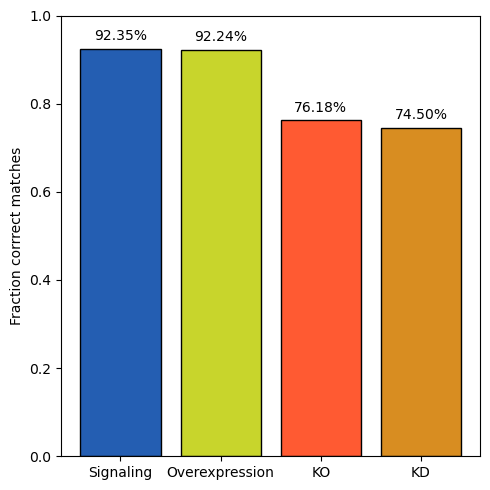

In [12]:
# Compute the fraction of matches for each perturbation type
signaling_match_rate = ((merged_df["signaling"] == merged_df["signaling_bc"]) & merged_df["signaling"].notna() & merged_df["signaling_bc"].notna()).sum() / merged_df[merged_df["signaling"].notna() & merged_df["signaling_bc"].notna()].shape[0]
overexp_match_rate = ((merged_df["gene"] == merged_df["gene_bc"]) & merged_df["gene"].notna() & merged_df["gene_bc"].notna()).sum() / merged_df[merged_df["gene"].notna() & merged_df["gene_bc"].notna()].shape[0]
ko_match_rate = ((merged_df["ko"] == merged_df["ko_bc"]) & merged_df["ko"].notna() & merged_df["ko_bc"].notna()).sum() / merged_df[merged_df["ko"].notna() & merged_df["ko_bc"].notna()].shape[0]
kd_match_rate = ((merged_df["kd"] == merged_df["kd_bc"]) & merged_df["kd"].notna() & merged_df["kd_bc"].notna()).sum() / merged_df[merged_df["kd"].notna() & merged_df["kd_bc"].notna()].shape[0]

# Prepare data for the bar plot
match_rates = {
    "Signaling": signaling_match_rate,
    "Overexpression": overexp_match_rate,
    "KO": ko_match_rate,
    "KD": kd_match_rate
}

# Plot the results
plt.figure(figsize=(5, 5))
plt.bar(match_rates.keys(), match_rates.values(), color=["#245EB2", "#C8D52C", "#FF5A32", "#D88D21"], edgecolor="black")
plt.ylabel("Fraction corrrect matches")
plt.title("")
plt.ylim(0, 1)
for i, v in enumerate(match_rates.values()):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontsize=10)
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/modification_correct_rate_bar_plot.svg", format="svg")
plt.show()


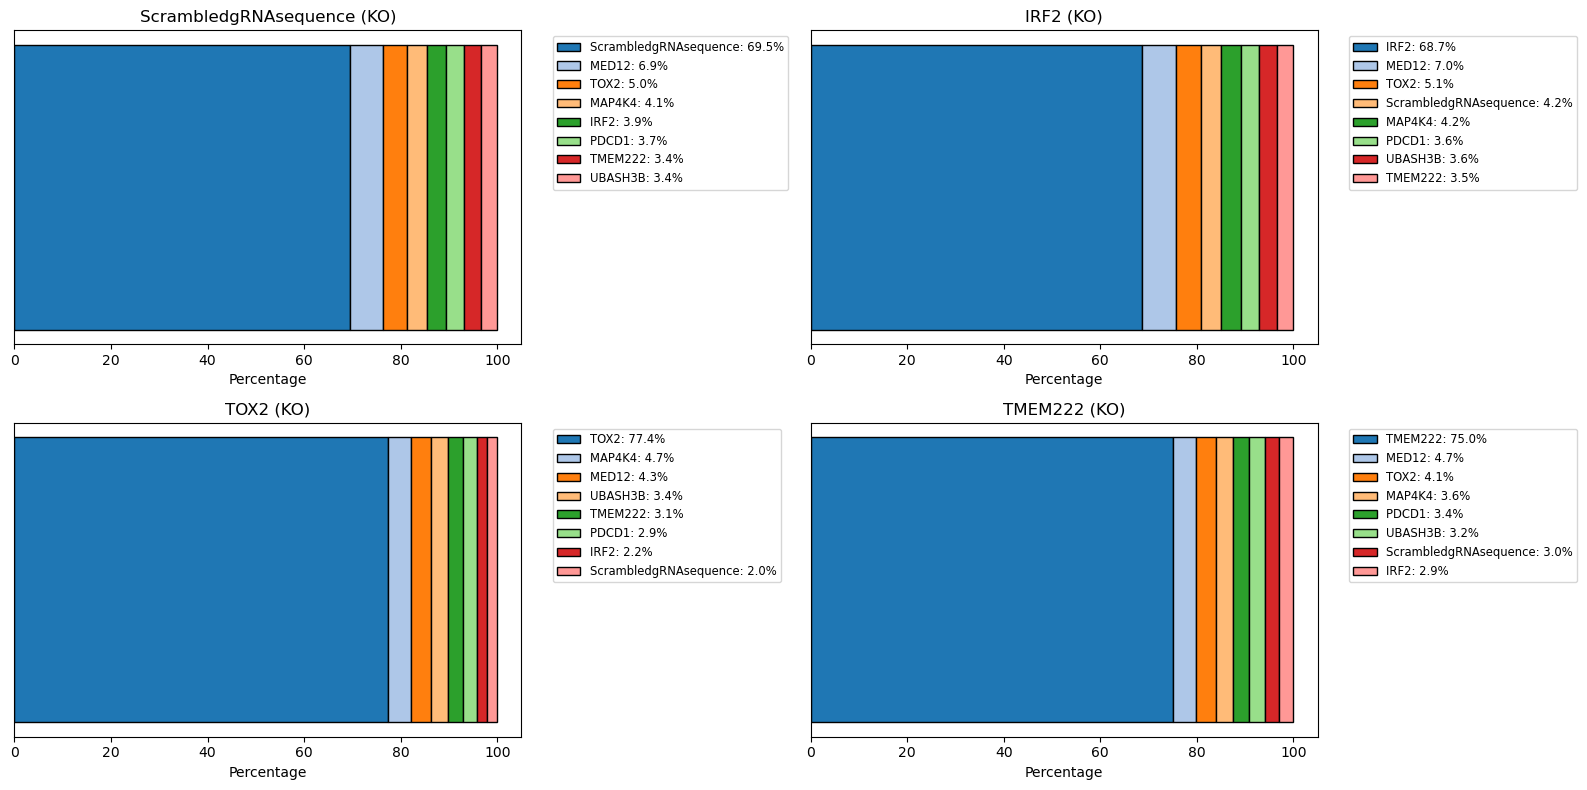

In [ ]:
def plot_barcode_distribution(ax, df, construct, pert_type="ko"):
    pert_type_bc = pert_type + "_bc"
    filtered_df = df[df[pert_type].notna() & df[pert_type_bc].notna()]
    filtered_df = filtered_df[filtered_df[pert_type] == construct]
    counts = filtered_df[pert_type_bc].value_counts(normalize=True) * 100
    
    bottom = 0
    colors = plt.cm.tab20.colors
    for i, (barcode, percentage) in enumerate(counts.items()):
        ax.barh(0, percentage, left=bottom, color=colors[i % len(colors)], edgecolor="black", label=f"{barcode}: {percentage:.1f}%")
        bottom += percentage
    
    ax.set_xlabel('Percentage')
    ax.set_title(f'{construct} ({pert_type.upper()})')
    ax.set_yticks([])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
plot_barcode_distribution(axes[0, 0], merged_df, "ScrambledgRNAsequence", "ko")
plot_barcode_distribution(axes[0, 1], merged_df, "IRF2", "ko")
plot_barcode_distribution(axes[1, 0], merged_df, "TOX2", "ko")
plot_barcode_distribution(axes[1, 1], merged_df, "TMEM222", "ko")
plt.tight_layout()
plt.show()

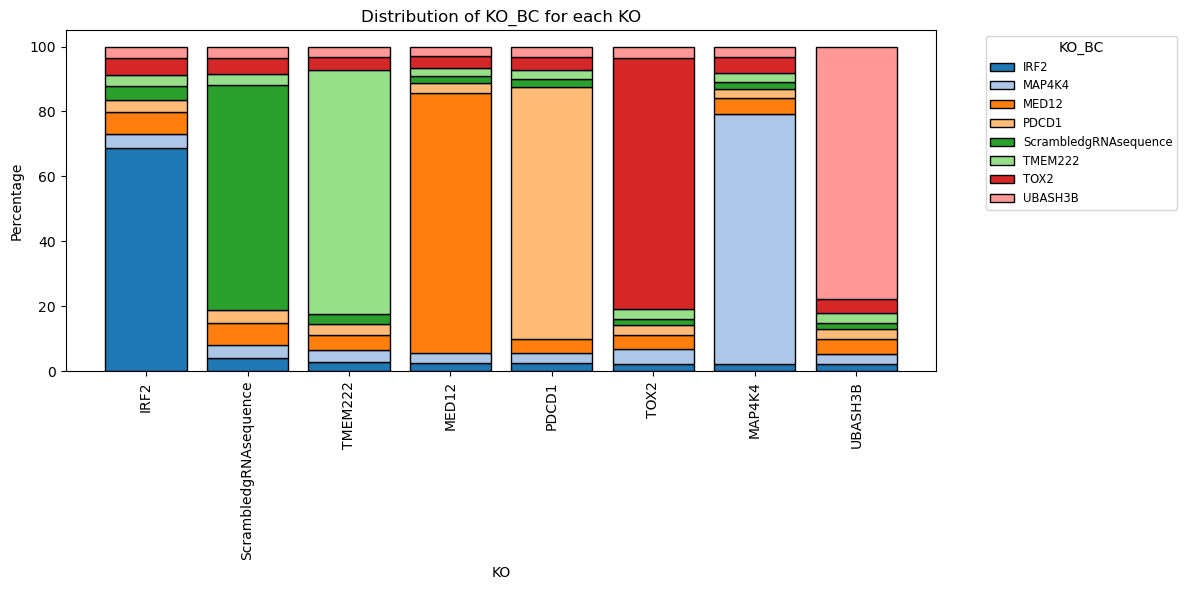

In [ ]:
data = []
unique_kos = merged_df['ko'].dropna().unique()

for ko in unique_kos:
    filtered_df = merged_df[merged_df['ko'] == ko]
    counts = filtered_df['ko_bc'].value_counts(normalize=True) * 100
    for barcode, percentage in counts.items():
        data.append({'ko': ko, 'ko_bc': barcode, 'percentage': percentage})

plot_data = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
colors = plt.cm.tab20.colors
bottoms = {ko: 0 for ko in unique_kos}

for i, (barcode, group) in enumerate(plot_data.groupby('ko_bc')):
    percentages = group.set_index('ko')['percentage'].sort_values(ascending=False)
    plt.bar(percentages.index, percentages, bottom=[bottoms[ko] for ko in percentages.index],
            color=colors[i % len(colors)], edgecolor="black", label=barcode)
    for ko in percentages.index:
        bottoms[ko] += percentages[ko]

plt.ylabel('Percentage')
plt.xlabel('KO')
plt.title('Distribution of KO_BC for each KO')
plt.xticks(rotation=90)
plt.legend(title='KO_BC', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/combo_ko_distribution.svg", format="svg")
plt.show()

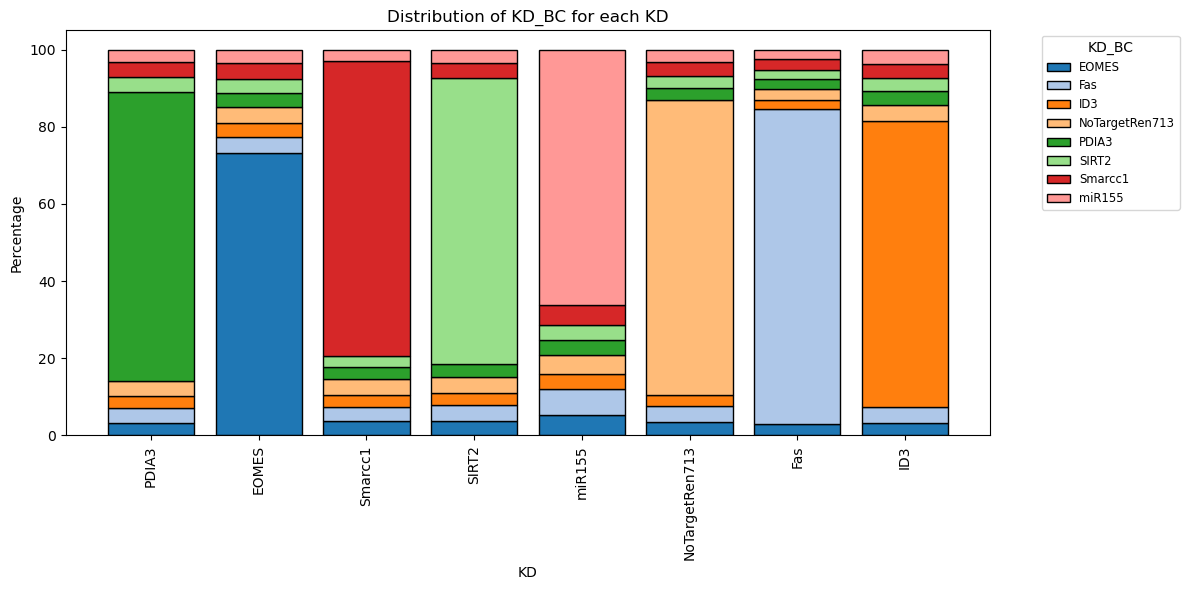

In [ ]:
data = []
unique_kds = merged_df['kd'].dropna().unique()

for kd in unique_kds:
    filtered_df = merged_df[merged_df['kd'] == kd]
    counts = filtered_df['kd_bc'].value_counts(normalize=True) * 100
    for barcode, percentage in counts.items():
        data.append({'kd': kd, 'kd_bc': barcode, 'percentage': percentage})

plot_data = pd.DataFrame(data)

plot_data.head()
plt.figure(figsize=(12, 6))
colors = plt.cm.tab20.colors
bottoms = {kd: 0 for kd in unique_kds}

for i, (barcode, group) in enumerate(plot_data.groupby('kd_bc')):
    percentages = group.set_index('kd')['percentage']
    plt.bar(percentages.index, percentages, bottom=[bottoms[kd] for kd in percentages.index],
            color=colors[i % len(colors)], edgecolor="black", label=barcode)
    for kd in percentages.index:
        bottoms[kd] += percentages[kd]

plt.ylabel('Percentage')
plt.xlabel('KD')
plt.title('Distribution of KD_BC for each KD')
plt.xticks(rotation=90)
plt.legend(title='KD_BC', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/combo_kd_distribution.svg", format="svg")
plt.show()

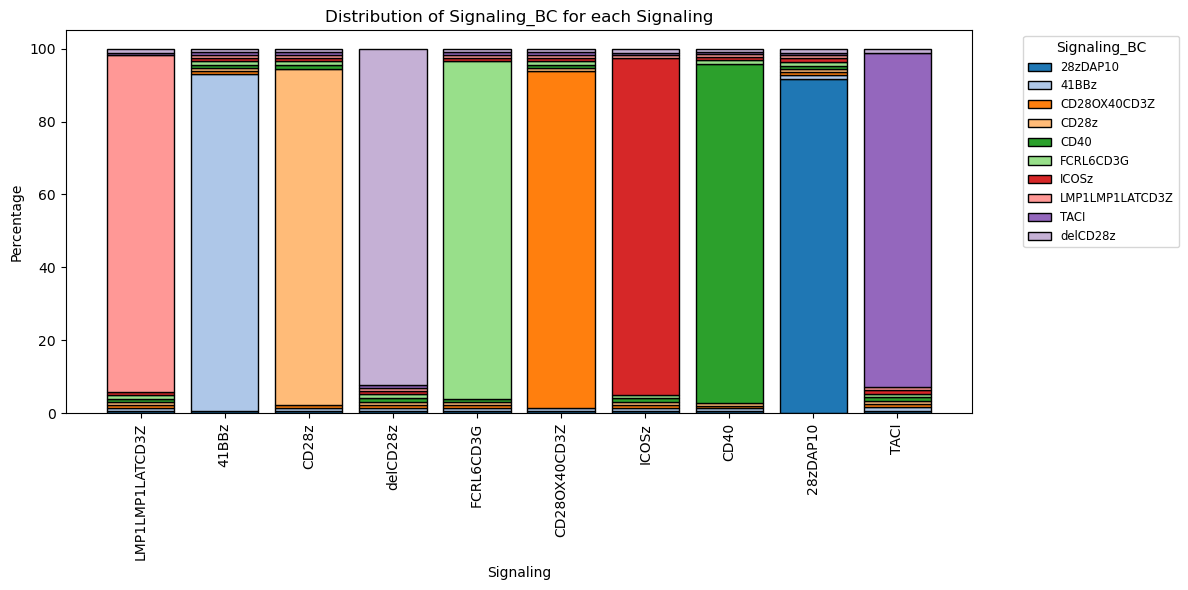

In [ ]:
data = []
unique_signalings = merged_df['signaling'].dropna().unique()

for signaling in unique_signalings:
    filtered_df = merged_df[merged_df['signaling'] == signaling]
    counts = filtered_df['signaling_bc'].value_counts(normalize=True) * 100
    for barcode, percentage in counts.items():
        data.append({'signaling': signaling, 'signaling_bc': barcode, 'percentage': percentage})

plot_data = pd.DataFrame(data)

plot_data.head()
plt.figure(figsize=(12, 6))
colors = plt.cm.tab20.colors
bottoms = {signaling: 0 for signaling in unique_signalings}

for i, (barcode, group) in enumerate(plot_data.groupby('signaling_bc')):
    percentages = group.set_index('signaling')['percentage']
    plt.bar(percentages.index, percentages, bottom=[bottoms[signaling] for signaling in percentages.index],
            color=colors[i % len(colors)], edgecolor="black", label=barcode)
    for signaling in percentages.index:
        bottoms[signaling] += percentages[signaling]

plt.ylabel('Percentage')
plt.xlabel('Signaling')
plt.title('Distribution of Signaling_BC for each Signaling')
plt.xticks(rotation=90)
plt.legend(title='Signaling_BC', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/combo_signaling_distribution.svg", format="svg")
plt.show()

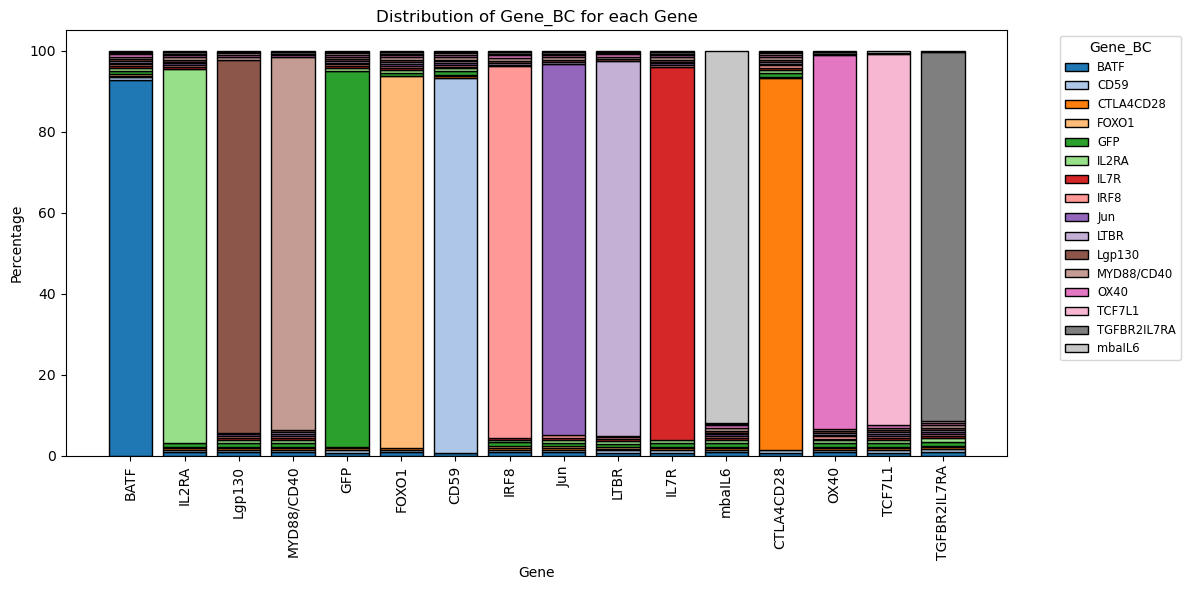

In [ ]:
data = []
unique_genes = merged_df['gene'].dropna().unique()

for gene in unique_genes:
    filtered_df = merged_df[merged_df['gene'] == gene]
    counts = filtered_df['gene_bc'].value_counts(normalize=True) * 100
    for barcode, percentage in counts.items():
        data.append({'gene': gene, 'gene_bc': barcode, 'percentage': percentage})

plot_data = pd.DataFrame(data)

plot_data.head()
plt.figure(figsize=(12, 6))
colors = plt.cm.tab20.colors
bottoms = {gene: 0 for gene in unique_genes}

for i, (barcode, group) in enumerate(plot_data.groupby('gene_bc')):
    percentages = group.set_index('gene')['percentage']
    plt.bar(percentages.index, percentages, bottom=[bottoms[gene] for gene in percentages.index],
            color=colors[i % len(colors)], edgecolor="black", label=barcode)
    for gene in percentages.index:
        bottoms[gene] += percentages[gene]

plt.ylabel('Percentage')
plt.xlabel('Gene')
plt.title('Distribution of Gene_BC for each Gene')
plt.xticks(rotation=90)
plt.legend(title='Gene_BC', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/combo_gene_distribution.svg", format="svg")
plt.show()

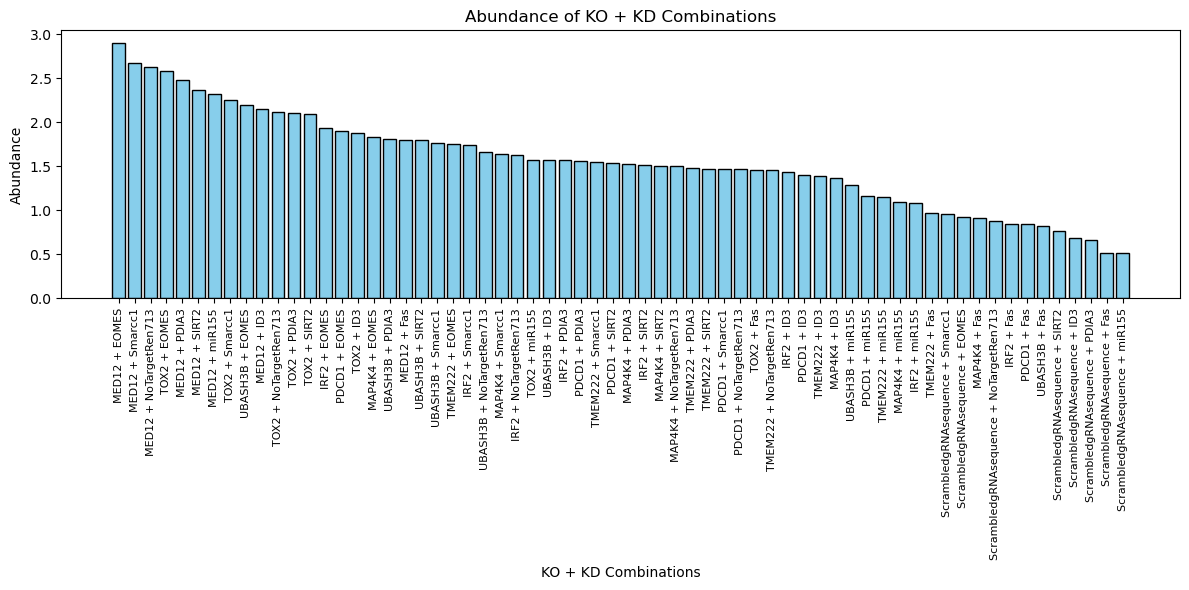

In [ ]:
combination_counts = merged_df.groupby(['ko', 'kd']).size().reset_index(name='count')

combination_counts['count'] = (combination_counts['count'] / combination_counts['count'].sum()) * 100
combination_counts = combination_counts.sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(
    x=combination_counts.apply(lambda row: f"{row['ko']} + {row['kd']}", axis=1),
    height=combination_counts['count'],
    color='skyblue',
    edgecolor='black'
)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('KO + KD Combinations')
plt.ylabel('Abundance')
plt.title('Abundance of KO + KD Combinations')
plt.tight_layout()
plt.show()


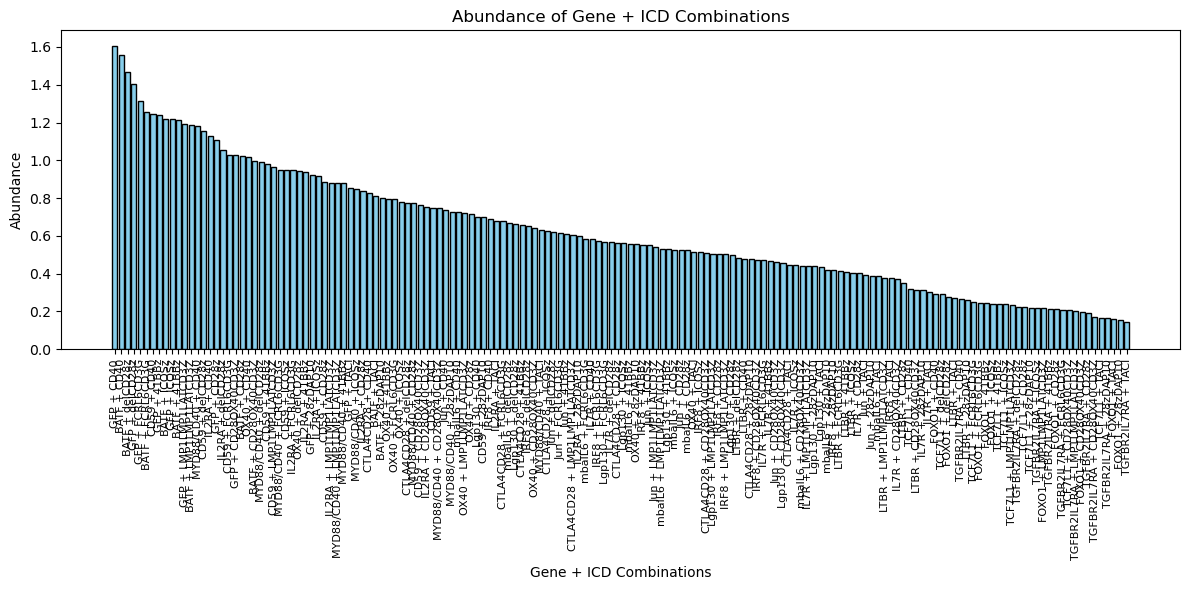

In [ ]:
combination_counts = merged_df.groupby(['gene', 'signaling']).size().reset_index(name='count')

combination_counts['count'] = (combination_counts['count'] / combination_counts['count'].sum()) * 100
combination_counts = combination_counts.sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(
    x=combination_counts.apply(lambda row: f"{row['gene']} + {row['signaling']}", axis=1),
    height=combination_counts['count'],
    color='skyblue',
    edgecolor='black'
)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Gene + ICD Combinations')
plt.ylabel('Abundance')
plt.title('Abundance of Gene + ICD Combinations')
plt.tight_layout()
plt.show()

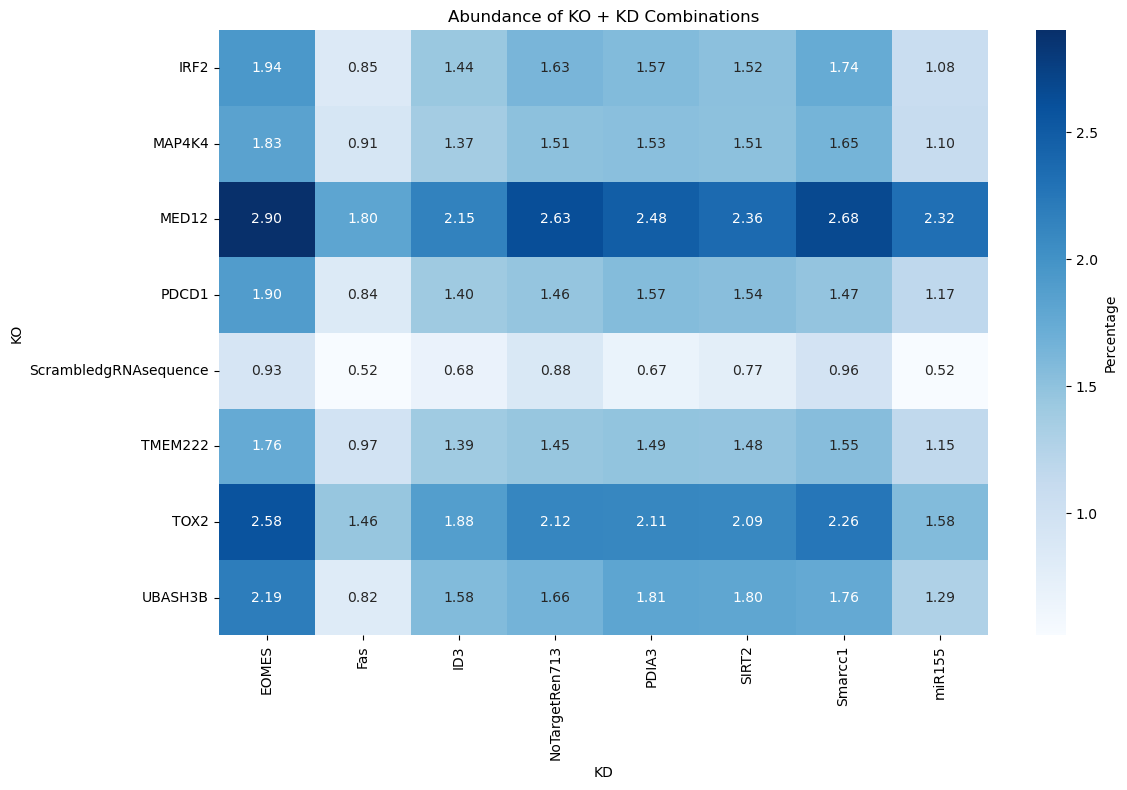

In [54]:
combination_counts = merged_df.groupby(['ko', 'kd']).size().reset_index(name='count')
combination_counts['count'] = (combination_counts['count'] / combination_counts['count'].sum()) * 100
combination_counts = combination_counts.sort_values(by='count', ascending=False)
heatmap_data = combination_counts.pivot(index='ko', columns='kd', values='count')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Percentage'})
plt.title('Abundance of KO + KD Combinations')
plt.xlabel('KD')
plt.ylabel('KO')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/paired_representation_heatmap_ko_kd.svg", format="svg")
plt.show()


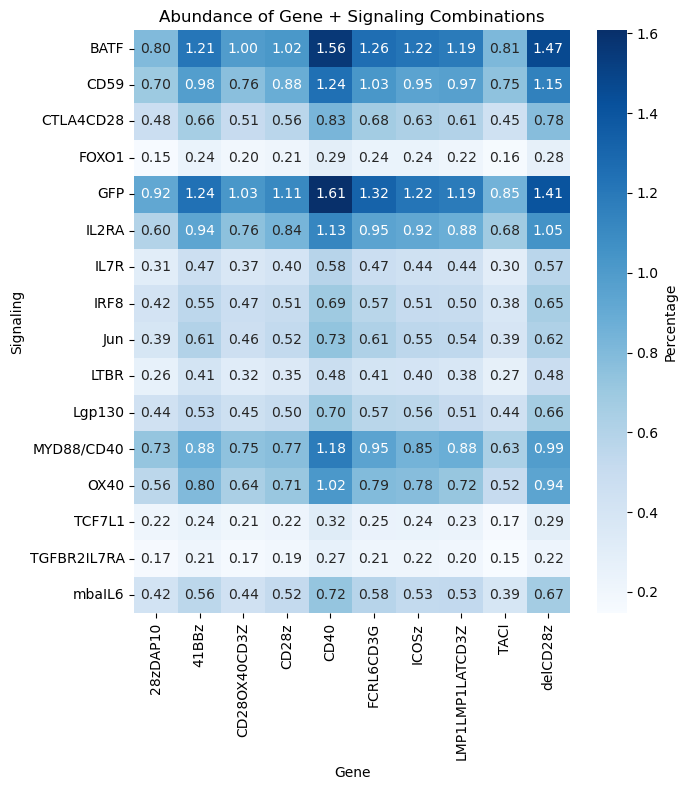

In [53]:
combination_counts = merged_df.groupby(['gene', 'signaling']).size().reset_index(name='count')
combination_counts['count'] = (combination_counts['count'] / combination_counts['count'].sum()) * 100
combination_counts = combination_counts.sort_values(by='count', ascending=False)
heatmap_data = combination_counts.pivot(index='gene', columns='signaling', values='count')
plt.figure(figsize=(7, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Percentage'})
plt.title('Abundance of Gene + Signaling Combinations')
plt.xlabel('Gene')
plt.ylabel('Signaling')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1975/3424128533.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categories, patch_artist=False)


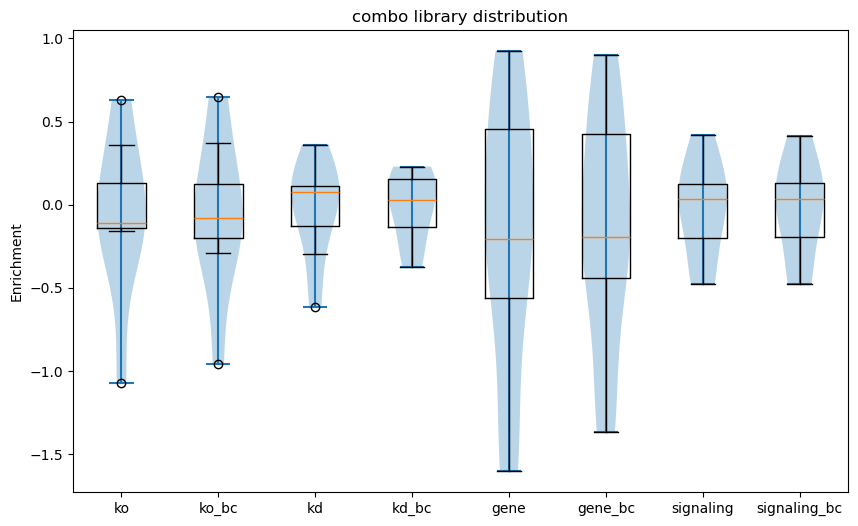

In [ ]:
categories = ['ko','ko_bc', 'kd','kd_bc', 'gene','gene_bc', 'signaling', 'signaling_bc']
data = [np.log2(merged_df[category].value_counts() / merged_df[category].value_counts().mean()) for category in categories]

plt.figure(figsize=(10, 6))
plt.violinplot(data, showmeans=False, showmedians=False)
plt.boxplot(data, labels=categories, patch_artist=False)

plt.ylabel('Enrichment')
plt.title('combo library distribution')
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/paired_representation_heatmap_signaling_gene.svg", format="svg")
plt.show()

In [71]:
# length of genes and length of signaling domains dictionaries
gene_lengths = {
    "IL2RA": 950,
    "IL7R": 1514,
    "LTBR": 1445,
    "CD59": 527,
    "TCF7L1": 1911,
    "Jun": 1146,
    "BATF": 512,
    "FOXO1": 2109,
    "IRF8": 1425,
    "GFP": 830,
    "mbaIL6": 1130,
    "Lgp130": 1276,
    "TGFBR2IL7RA": 2071,
    "CTLA4CD28": 837,
    "OX40": 978,
    "MYD88/CD40": 808,
}

signaling_lengths = {
    "CD28z": 794,
    "41BBz": 809,
    "ICOSz": 803,
    "TACI": 1014,
    "28zDAP10": 875,
    "CD28OX40CD3Z": 803,
    "CD40": 692,
    "LMP1LMP1LATCD3Z": 849,
    "FCRL6CD3G": 998,
    "delCD28z": 803,
}
constant_prefix_length = 1902
constant_suffix_length = 831

merged_df["length"] = constant_prefix_length + merged_df["gene"].map(gene_lengths) + merged_df["signaling"].map(signaling_lengths) + constant_suffix_length

In [72]:
merged_df.gene.unique()

array(['BATF', 'IL2RA', 'Lgp130', nan, 'MYD88/CD40', 'GFP', 'FOXO1',
       'CD59', 'IRF8', 'Jun', 'LTBR', 'IL7R', 'mbaIL6', 'CTLA4CD28',
       'OX40', 'TCF7L1', 'TGFBR2IL7RA'], dtype=object)

In [73]:
merged_df.head()

,signaling_bc,gene_bc,triplex_bc,ko_bc,kd_bc,ko,kd,gene,signaling,length
Key,,,,,,,,,,
m84127_250131_231902_s2/100007955/ccs,LMP1LMP1LATCD3Z,BATF,triplex,MAP4K4,PDIA3,TOX2,PDIA3,BATF,LMP1LMP1LATCD3Z,4094.0
m84127_250131_231902_s2/100007962/ccs,TACI,IL2RA,triplex,IRF2,Smarcc1,TOX2,EOMES,IL2RA,41BBz,4492.0
m84127_250131_231902_s2/100007963/ccs,CD28z,Lgp130,triplex,PDCD1,EOMES,PDCD1,EOMES,Lgp130,CD28z,4803.0
m84127_250131_231902_s2/100007966/ccs,CD40,BATF,triplex,TMEM222,Smarcc1,TMEM222,PDIA3,BATF,delCD28z,4048.0
m84127_250131_231902_s2/100007968/ccs,NaN,MYD88/CD40,triplex,MED12,Smarcc1,MED12,Smarcc1,NaN,FCRL6CD3G,NaN


                       barcode_count  construct_count
IRF2                          867150           994129
MAP4K4                       1022443           960880
MED12                        1662161          1630537
PDCD1                         980154           963505
ScrambledgRNAsequence         545615           502716
TMEM222                       939742           946155
TOX2                         1367818          1354144
UBASH3B                      1092935          1092744


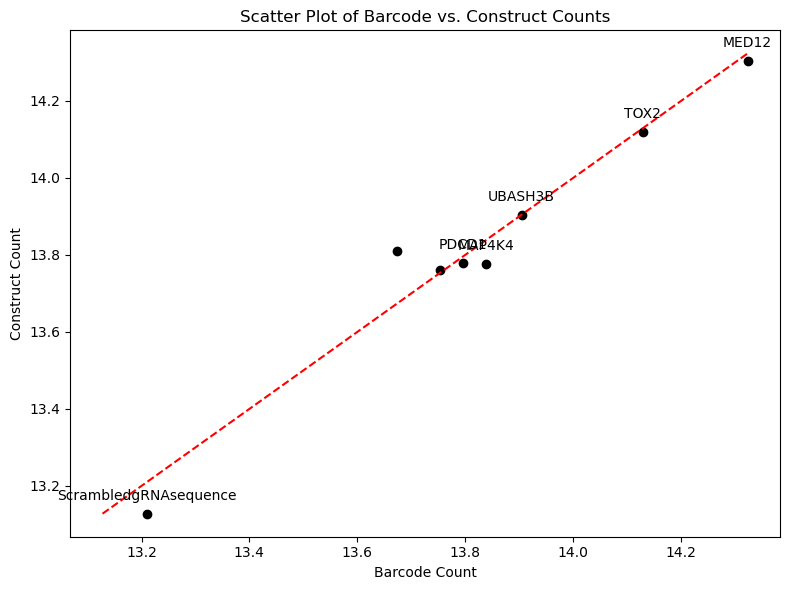

In [ ]:
barcode_counts = merged_df['ko_bc'].value_counts()
construct_counts = merged_df['ko'].value_counts()

plot_df = pd.DataFrame({'barcode_count': barcode_counts, 'construct_count': construct_counts})
print(plot_df)
plt.figure(figsize=(8, 6))
plt.scatter(np.log(plot_df['barcode_count']), np.log(plot_df['construct_count']), c="black")
plt.xlabel('Barcode Count')
plt.ylabel('Construct Count')
plt.title('Scatter Plot of Barcode vs. Construct Counts')

min_val = min(np.log(plot_df['barcode_count']).min(), np.log(plot_df['construct_count']).min())
max_val = max(np.log(plot_df['barcode_count']).max(), np.log(plot_df['construct_count']).max())

plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y')

# Identify points above the y=x line
above_line = (np.log(plot_df['barcode_count'])) > np.log(plot_df['construct_count'])

# Get the indices of these points
barcodes_above = plot_df.index[above_line]

for barcode in barcodes_above:
    x = np.log(plot_df.loc[barcode, 'barcode_count'])
    y = np.log(plot_df.loc[barcode, 'construct_count'])
    plt.annotate(barcode, (x, y), textcoords="offset points", xytext=(0,10), ha='center') 

plt.tight_layout()
plt.show()

                barcode_count  construct_count
EOMES                 1239633          1325325
Fas                    892550           673267
ID3                    987033           983120
NoTargetRen713        1170742          1100774
PDIA3                 1086918          1092333
SIRT2                 1066517          1080252
Smarcc1               1201072          1160836
miR155                 816275           841211


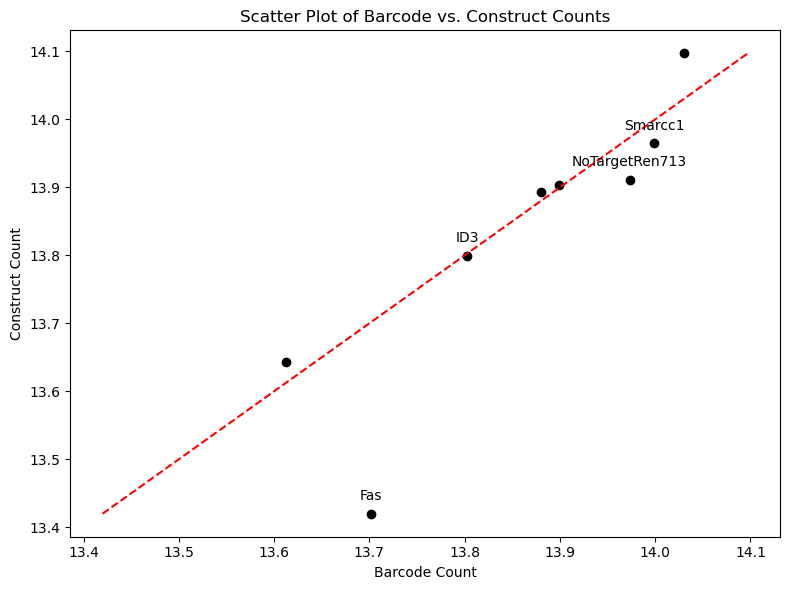

In [ ]:
barcode_counts = merged_df['kd_bc'].value_counts()
construct_counts = merged_df['kd'].value_counts()

plot_df = pd.DataFrame({'barcode_count': barcode_counts, 'construct_count': construct_counts})
print(plot_df)
plt.figure(figsize=(8, 6))
plt.scatter(np.log(plot_df['barcode_count']), np.log(plot_df['construct_count']), c="black")
plt.xlabel('Barcode Count')
plt.ylabel('Construct Count')
plt.title('Scatter Plot of Barcode vs. Construct Counts')

min_val = min(np.log(plot_df['barcode_count']).min(), np.log(plot_df['construct_count']).min())
max_val = max(np.log(plot_df['barcode_count']).max(), np.log(plot_df['construct_count']).max())

plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y')

above_line = (np.log(plot_df['barcode_count'])) > np.log(plot_df['construct_count'])

barcodes_above = plot_df.index[above_line]

for barcode in barcodes_above:
    x = np.log(plot_df.loc[barcode, 'barcode_count'])
    y = np.log(plot_df.loc[barcode, 'construct_count'])
    plt.annotate(barcode, (x, y), textcoords="offset points", xytext=(0,10), ha='center') 

plt.tight_layout()
plt.show()

             barcode_count  construct_count
BATF                818173           792938
CD59                665875           648256
CTLA4CD28           439125           428474
FOXO1               212992           159500
GFP                 869763           824771
IL2RA               641551           606415
IL7R                356050           305729
IRF8                399962           370281
Jun                 390168           378808
LTBR                306354           265220
Lgp130              413710           374599
MYD88/CD40          620827           594350
OX40                538421           521732
TCF7L1              205380           171035
TGFBR2IL7RA         180389           143221
mbaIL6              393877           373464


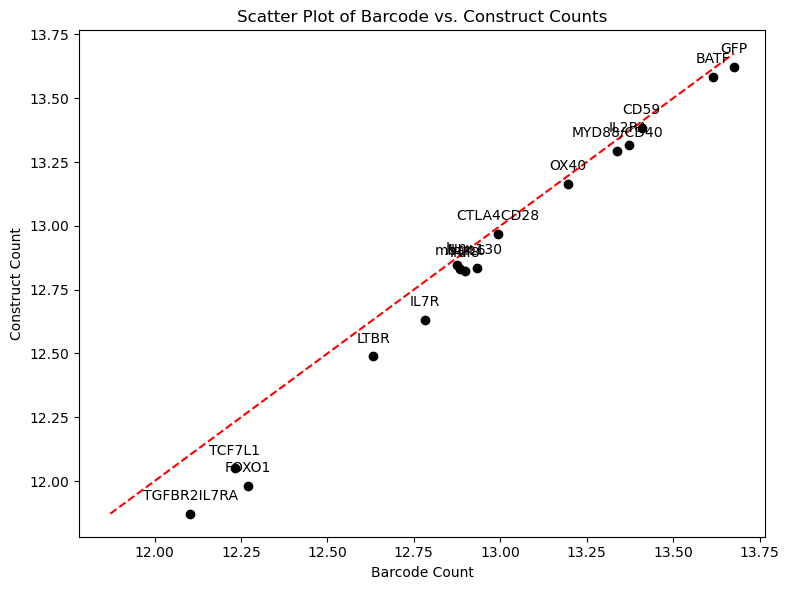

In [ ]:
barcode_counts = merged_df['gene_bc'].value_counts()
construct_counts = merged_df['gene'].value_counts()

plot_df = pd.DataFrame({'barcode_count': barcode_counts, 'construct_count': construct_counts})
print(plot_df)
plt.figure(figsize=(8, 6))
plt.scatter(np.log(plot_df['barcode_count']), np.log(plot_df['construct_count']), c="black")
plt.xlabel('Barcode Count')
plt.ylabel('Construct Count')
plt.title('Scatter Plot of Barcode vs. Construct Counts')

min_val = min(np.log(plot_df['barcode_count']).min(), np.log(plot_df['construct_count']).min())
max_val = max(np.log(plot_df['barcode_count']).max(), np.log(plot_df['construct_count']).max())

plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y')

above_line = (np.log(plot_df['barcode_count'])) > np.log(plot_df['construct_count'])

barcodes_above = plot_df.index[above_line]

for barcode in barcodes_above:
    x = np.log(plot_df.loc[barcode, 'barcode_count'])
    y = np.log(plot_df.loc[barcode, 'construct_count'])
    plt.annotate(barcode, (x, y), textcoords="offset points", xytext=(0,10), ha='center') 

plt.tight_layout()
plt.show()

                 barcode_count  construct_count
28zDAP10                651988           662256
41BBz                   967245           966340
CD28OX40CD3Z            782284           778318
CD28z                   825665           823416
CD40                   1210686          1211280
FCRL6CD3G              1003513           998302
ICOSz                   940447           939688
LMP1LMP1LATCD3Z         917597           921039
TACI                    652665           651562
delCD28z               1123919          1122557


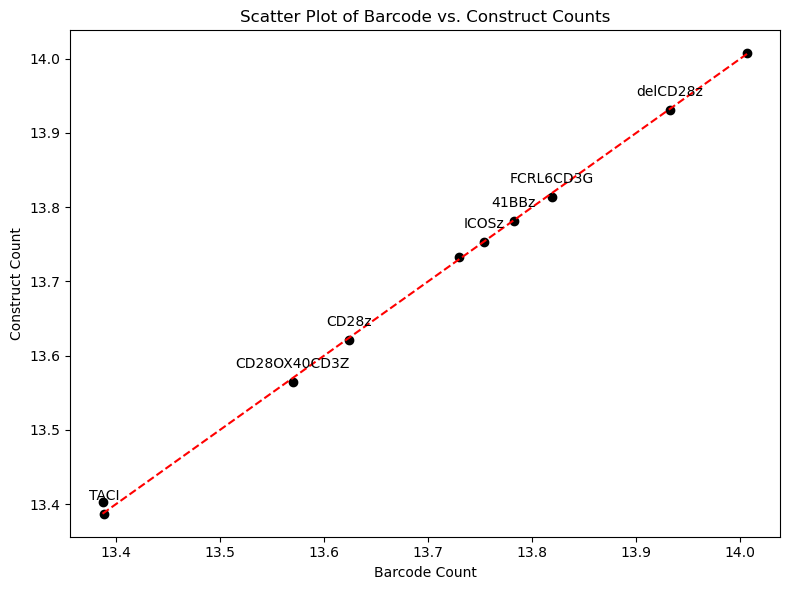

In [ ]:
barcode_counts = merged_df['signaling_bc'].value_counts()
construct_counts = merged_df['signaling'].value_counts()

plot_df = pd.DataFrame({'barcode_count': barcode_counts, 'construct_count': construct_counts})
print(plot_df)
plt.figure(figsize=(8, 6))
plt.scatter(np.log(plot_df['barcode_count']), np.log(plot_df['construct_count']), c="black")
plt.xlabel('Barcode Count')
plt.ylabel('Construct Count')
plt.title('Scatter Plot of Barcode vs. Construct Counts')

min_val = min(np.log(plot_df['barcode_count']).min(), np.log(plot_df['construct_count']).min())
max_val = max(np.log(plot_df['barcode_count']).max(), np.log(plot_df['construct_count']).max())

plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y')

above_line = (np.log(plot_df['barcode_count'])) > np.log(plot_df['construct_count'])

barcodes_above = plot_df.index[above_line]

for barcode in barcodes_above:
    x = np.log(plot_df.loc[barcode, 'barcode_count'])
    y = np.log(plot_df.loc[barcode, 'construct_count'])
    plt.annotate(barcode, (x, y), textcoords="offset points", xytext=(0,10), ha='center') 

plt.tight_layout()
plt.show()

In [5]:
total_reads = merged_df.shape[0]
complete_reads = merged_df.dropna().shape[0]

complete_barcodes = merged_df[["signaling_bc", "ko_bc", "kd_bc", "gene_bc"]].dropna().shape[0]
complete_constructs = merged_df[["signaling", "ko", "kd", "gene"]].dropna().shape[0]

fidelity = sum(
    (merged_df.ko_bc == merged_df.ko) &
    (merged_df.kd_bc == merged_df.kd) &
    (merged_df.gene_bc == merged_df.gene) &
    (merged_df.signaling_bc == merged_df.signaling)
) / complete_reads

# Barcode undetected
kd_bc_missing = merged_df['kd_bc'].isna().sum() / total_reads
ko_bc_missing = merged_df['ko_bc'].isna().sum() / total_reads
gene_bc_missing = merged_df['gene_bc'].isna().sum() / total_reads
signaling_bc_missing = merged_df['signaling_bc'].isna().sum() / total_reads

# Construct undetected
kd_missing = merged_df['kd'].isna().sum() / total_reads
ko_missing = merged_df['ko'].isna().sum() / total_reads
gene_missing = merged_df['gene'].isna().sum() / total_reads
signaling_missing = merged_df['signaling'].isna().sum() / total_reads

ko_correct = sum(merged_df.ko_bc == merged_df.ko) / total_reads
kd_correct = sum(merged_df.kd_bc == merged_df.kd) / total_reads
gene_correct = sum(merged_df.gene_bc == merged_df.gene) / total_reads
signaling_correct = sum(merged_df.signaling_bc == merged_df.signaling) / total_reads

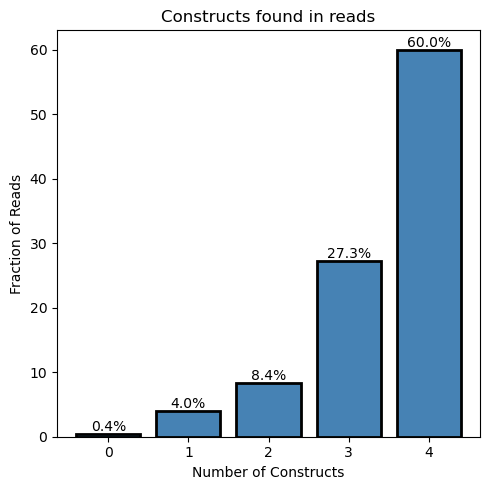

In [6]:
df = (merged_df['kd'].notna().astype(int) + merged_df['ko'].notna().astype(int) + merged_df['gene'].notna().astype(int) + merged_df['signaling'].notna().astype(int)).value_counts().to_frame()
df["correct_constructs"] = df.index
df["count"] = round(100 * df["count"] / total_reads, 1)

plt.figure(figsize=(5, 5))
bars = plt.bar(df["correct_constructs"], df["count"], color="steelblue", edgecolor="black", linewidth=2)
plt.xlabel("Number of Constructs")
plt.ylabel("Fraction of Reads")
plt.title("Constructs found in reads")
plt.xticks(df["correct_constructs"])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(yval)+"%", va='bottom', ha='center')

plt.tight_layout()
plt.show()

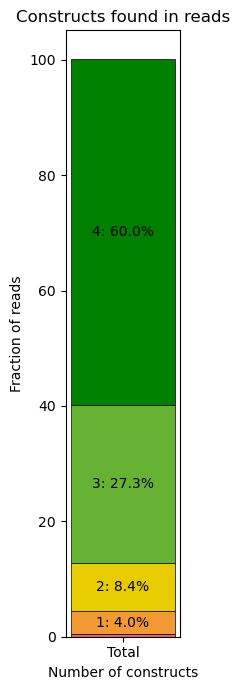

In [14]:
df = (merged_df['kd'].notna().astype(int) + merged_df['ko'].notna().astype(int) + merged_df['gene'].notna().astype(int) + merged_df['signaling'].notna().astype(int)).value_counts().to_frame()
df["correct_constructs"] = df.index
df["count"] = round(100 * df["count"] / total_reads, 1)
df = df.sort_values("correct_constructs").reset_index(drop=True)

plt.figure(figsize=(2, 7))
bottom = 0
colors = [(0.9, 0.4, 0.4), (0.95, 0.6, 0.2), (0.9, 0.8, 0.0), (0.4, 0.7, 0.2), (0.0, 0.5, 0.0)]
for i, row in df.iterrows():
    height = row["count"]
    plt.bar(0, height, bottom=bottom, color=colors[i % len(colors)], edgecolor="black", linewidth=0.5)
    if height > 1:
        plt.text(0, bottom + height/2, f"{i}: {height}%", ha="center", va="center")
    bottom += height

plt.xlabel("Number of constructs")
plt.ylabel("Fraction of reads")
plt.title("Constructs found in reads")
plt.xticks([0], ["Total"])
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/constructs_in_reads_bar_plot.svg", format="svg")
plt.show()

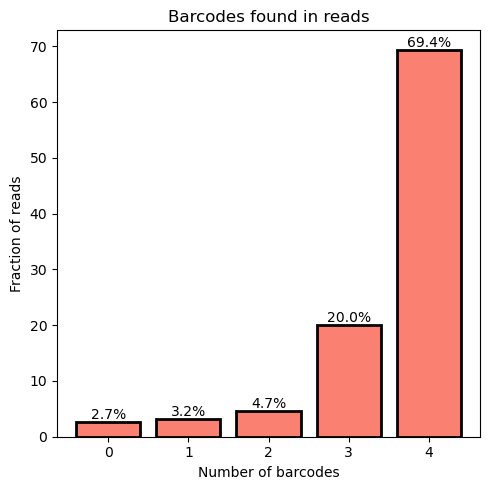

In [83]:
df = (merged_df['kd_bc'].notna().astype(int) + merged_df['ko_bc'].notna().astype(int) + merged_df['gene_bc'].notna().astype(int) + merged_df['signaling_bc'].notna().astype(int)).value_counts().to_frame()
df["correct_barcodes"] = df.index
df["count"] = round(100 * df["count"] / total_reads, 1)

plt.figure(figsize=(5, 5))
bars = plt.bar(df["correct_barcodes"], df["count"], color="salmon", edgecolor="black", linewidth=2)
plt.xlabel("Number of barcodes")
plt.ylabel("Fraction of reads")
plt.title("Barcodes found in reads")
plt.xticks(df["correct_barcodes"])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(yval)+"%", va='bottom', ha='center')

plt.tight_layout()
plt.show()

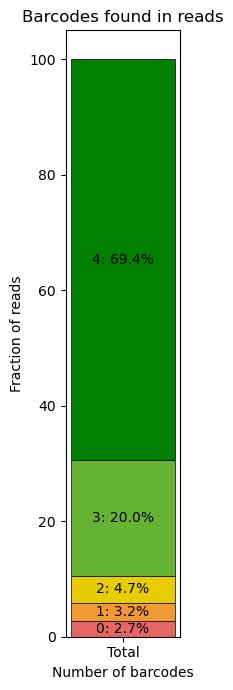

In [15]:
df = (merged_df['kd_bc'].notna().astype(int) + merged_df['ko_bc'].notna().astype(int) + merged_df['gene_bc'].notna().astype(int) + merged_df['signaling_bc'].notna().astype(int)).value_counts().to_frame()
df["correct_barcodes"] = df.index
df["count"] = round(100 * df["count"] / total_reads, 1)
df = df.sort_values("correct_barcodes").reset_index(drop=True)

plt.figure(figsize=(2, 7))
bottom = 0
# colors = ["mediumseagreen", "skyblue", "salmon", "orange", "purple"]
colors = [(0.9, 0.4, 0.4), (0.95, 0.6, 0.2), (0.9, 0.8, 0.0), (0.4, 0.7, 0.2), (0.0, 0.5, 0.0)]
for i, row in df.iterrows():
    height = row["count"]
    plt.bar(0, height, bottom=bottom, color=colors[i % len(colors)], edgecolor="black", linewidth=0.5)
    plt.text(0, bottom + height/2, f"{i}: {height}%", ha="center", va="center")
    bottom += height

plt.xlabel("Number of barcodes")
plt.ylabel("Fraction of reads")
plt.title("Barcodes found in reads")
plt.xticks([0], ["Total"])
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/barcodes_in_reads_bar_plot.svg", format="svg")
plt.show()

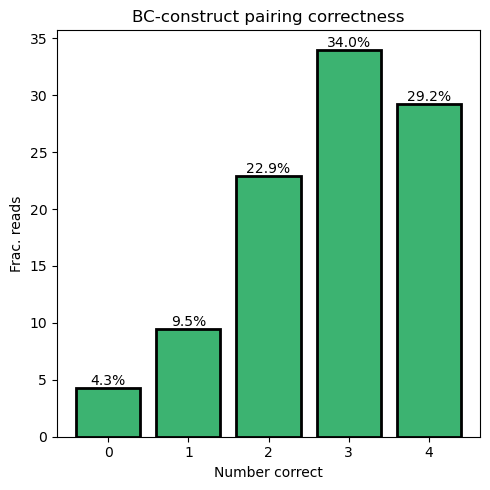

In [85]:
# number of barcodes and constructs which match
df = (
    (merged_df['kd_bc'] == merged_df['kd']).astype(int) +
    (merged_df['ko_bc'] == merged_df['ko']).astype(int) +
    (merged_df['gene_bc'] == merged_df['gene']).astype(int) +
    (merged_df['signaling_bc'] == merged_df['signaling']).astype(int)
).value_counts().to_frame()
df["correct"] = df.index
df["count"] = round(100 * df["count"] / total_reads, 1)

plt.figure(figsize=(5, 5))
bars = plt.bar(df["correct"], df["count"], color="mediumseagreen", edgecolor="black", linewidth=2)
plt.xlabel("Number correct")
plt.ylabel("Frac. reads")
plt.title("BC-construct pairing correctness")
plt.xticks(df["correct"])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(yval)+"%", va='bottom', ha='center')

plt.tight_layout()
plt.show()

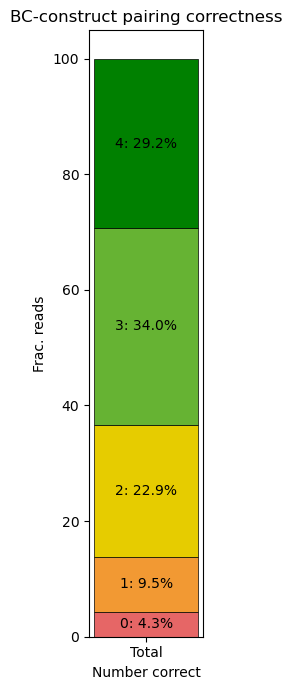

In [16]:
df = (
    (merged_df['kd_bc'] == merged_df['kd']).astype(int) +
    (merged_df['ko_bc'] == merged_df['ko']).astype(int) +
    (merged_df['gene_bc'] == merged_df['gene']).astype(int) +
    (merged_df['signaling_bc'] == merged_df['signaling']).astype(int)
).value_counts().to_frame()
df["correct"] = df.index
df["count"] = round(100 * df["count"] / total_reads, 1)
df = df.sort_values("correct").reset_index(drop=True)

plt.figure(figsize=(2, 7))
bottom = 0
# colors = ["mediumseagreen", "skyblue", "salmon", "orange", "purple"]
colors = [(0.9, 0.4, 0.4), (0.95, 0.6, 0.2), (0.9, 0.8, 0.0), (0.4, 0.7, 0.2), (0.0, 0.5, 0.0)]
for i, row in df.iterrows():
    height = row["count"]
    plt.bar(0, height, bottom=bottom, color=colors[i % len(colors)], edgecolor="black", linewidth=0.5)
    plt.text(0, bottom + height/2, f"{i}: {height}%", ha="center", va="center")
    bottom += height

plt.xlabel("Number correct")
plt.ylabel("Frac. reads")
plt.title("BC-construct pairing correctness")
plt.xticks([0], ["Total"])
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/number_correct_pairings_bar_plot.svg", format="svg")
plt.show()

In [88]:
# print results
print(f"Fraction of reads with 4 constructs & 4 barcodes detected: {round(complete_reads / total_reads, 2)}")
print(f"Fraction of reads with 4 constructs detected:              {round(complete_constructs / total_reads, 2)}")
print(f"Fraction of reads with 4 barcodes detected:                {round(complete_barcodes / total_reads, 2)}")
print(f"Fidelity (correctness among 4 BC & 4 construct reads):     {round(fidelity*100, 2)}%")

print(f"\nKO BC missing:         {round(kd_bc_missing*100, 2)}%")
print(f"KD BC missing:         {round(ko_bc_missing*100, 2)}%")
print(f"Gene BC missing:       {round(gene_bc_missing*100, 2)}%")
print(f"Signaling BC missing:  {round(signaling_bc_missing*100, 2)}%")

print(f"\nKO missing:         {round(kd_missing*100, 2)}%")
print(f"KD missing:         {round(ko_missing*100, 2)}%")
print(f"Gene missing:       {round(gene_missing*100, 2)}%")
print(f"Signaling missing:  {round(signaling_missing*100, 2)}%")

print(f"\nKO fidelity:         {round(ko_correct*100, 2)}%")
print(f"KD fidelity:         {round(kd_correct*100, 2)}%")
print(f"Gene fidelity:       {round(gene_correct*100, 2)}%")
print(f"Signaling fidelity:  {round(signaling_correct*100, 2)}%")

Fraction of reads with 4 constructs & 4 barcodes detected: 0.55
Fraction of reads with 4 constructs detected:              0.6
Fraction of reads with 4 barcodes detected:                0.69
Fidelity (correctness among 4 BC & 4 construct reads):     53.35%

KO BC missing:         11.5%
KD BC missing:         11.31%
Gene BC missing:       22.04%
Signaling BC missing:  5.06%

KO missing:         13.63%
KD missing:         11.66%
Gene missing:       27.21%
Signaling missing:  5.07%

KO fidelity:         64.37%
KD fidelity:         62.36%
Gene fidelity:       63.21%
Signaling fidelity:  84.25%


In [89]:
merged_df[["signaling_bc", "ko_bc", "kd_bc", "gene_bc"]].head()

,signaling_bc,ko_bc,kd_bc,gene_bc
Key,,,,
m84127_250131_231902_s2/100007955/ccs,LMP1LMP1LATCD3Z,MAP4K4,PDIA3,BATF
m84127_250131_231902_s2/100007962/ccs,TACI,IRF2,Smarcc1,IL2RA
m84127_250131_231902_s2/100007963/ccs,CD28z,PDCD1,EOMES,Lgp130
m84127_250131_231902_s2/100007966/ccs,CD40,TMEM222,Smarcc1,BATF
m84127_250131_231902_s2/100007968/ccs,NaN,MED12,Smarcc1,MYD88/CD40


In [90]:
fidelity = sum(
    (merged_df.ko_bc == merged_df.ko) &
    (merged_df.kd_bc == merged_df.kd) &
    (merged_df.gene_bc == merged_df.gene) &
    (merged_df.signaling_bc == merged_df.signaling)
) / merged_df.shape[0]
print(fidelity)

0.29171237521657406


In [91]:
complete_reads

5226857

In [92]:
sum(
    (merged_df.ko_bc == merged_df.ko) &
    (merged_df.kd_bc == merged_df.kd) &
    (merged_df.gene_bc == merged_df.gene) &
    (merged_df.signaling_bc == merged_df.signaling)
)

2788672

In [93]:
merged_df.dropna().head(10)

,signaling_bc,gene_bc,triplex_bc,ko_bc,kd_bc,ko,kd,gene,signaling,length
Key,,,,,,,,,,
m84127_250131_231902_s2/100007955/ccs,LMP1LMP1LATCD3Z,BATF,triplex,MAP4K4,PDIA3,TOX2,PDIA3,BATF,LMP1LMP1LATCD3Z,4094.0
m84127_250131_231902_s2/100007962/ccs,TACI,IL2RA,triplex,IRF2,Smarcc1,TOX2,EOMES,IL2RA,41BBz,4492.0
m84127_250131_231902_s2/100007963/ccs,CD28z,Lgp130,triplex,PDCD1,EOMES,PDCD1,EOMES,Lgp130,CD28z,4803.0
m84127_250131_231902_s2/100007966/ccs,CD40,BATF,triplex,TMEM222,Smarcc1,TMEM222,PDIA3,BATF,delCD28z,4048.0
m84127_250131_231902_s2/100007973/ccs,41BBz,Jun,triplex,MAP4K4,Smarcc1,MAP4K4,Smarcc1,GFP,41BBz,4372.0
m84127_250131_231902_s2/100007975/ccs,41BBz,GFP,triplex,TMEM222,miR155,TMEM222,miR155,GFP,41BBz,4372.0
m84127_250131_231902_s2/100007978/ccs,CD28OX40CD3Z,GFP,triplex,TOX2,Fas,TMEM222,EOMES,FOXO1,CD28OX40CD3Z,5645.0
m84127_250131_231902_s2/100007979/ccs,CD28z,CD59,triplex,MED12,NoTargetRen713,TOX2,NoTargetRen713,CD59,CD28z,4054.0
m84127_250131_231902_s2/100007982/ccs,delCD28z,IRF8,triplex,MED12,Fas,UBASH3B,Fas,IRF8,delCD28z,4961.0


In [95]:
complete_reads_df = merged_df.dropna()
complete_reads_df["full_bc"] = complete_reads_df["ko_bc"] + "-" + complete_reads_df["kd_bc"] + "-" + complete_reads_df["signaling_bc"] + "-" + complete_reads_df["gene_bc"]
complete_reads_df["full_construct"] = complete_reads_df["ko"] + "-" + complete_reads_df["kd"] + "-" + complete_reads_df["signaling"] + "-" + complete_reads_df["gene"]
complete_reads_df.head()

/tmp/ipykernel_3645/2693106746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_reads_df["full_bc"] = complete_reads_df["ko_bc"] + "-" + complete_reads_df["kd_bc"] + "-" + complete_reads_df["signaling_bc"] + "-" + complete_reads_df["gene_bc"]
/tmp/ipykernel_3645/2693106746.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_reads_df["full_construct"] = complete_reads_df["ko"] + "-" + complete_reads_df["kd"] + "-" + complete_reads_df["signaling"] + "-" + complete_reads_df["gene"]


,signaling_bc,gene_bc,triplex_bc,ko_bc,kd_bc,ko,kd,gene,signaling,length,full_bc,full_construct
Key,,,,,,,,,,,,
m84127_250131_231902_s2/100007955/ccs,LMP1LMP1LATCD3Z,BATF,triplex,MAP4K4,PDIA3,TOX2,PDIA3,BATF,LMP1LMP1LATCD3Z,4094.0,MAP4K4-PDIA3-LMP1LMP1LATCD3Z-BATF,TOX2-PDIA3-LMP1LMP1LATCD3Z-BATF
m84127_250131_231902_s2/100007962/ccs,TACI,IL2RA,triplex,IRF2,Smarcc1,TOX2,EOMES,IL2RA,41BBz,4492.0,IRF2-Smarcc1-TACI-IL2RA,TOX2-EOMES-41BBz-IL2RA
m84127_250131_231902_s2/100007963/ccs,CD28z,Lgp130,triplex,PDCD1,EOMES,PDCD1,EOMES,Lgp130,CD28z,4803.0,PDCD1-EOMES-CD28z-Lgp130,PDCD1-EOMES-CD28z-Lgp130
m84127_250131_231902_s2/100007966/ccs,CD40,BATF,triplex,TMEM222,Smarcc1,TMEM222,PDIA3,BATF,delCD28z,4048.0,TMEM222-Smarcc1-CD40-BATF,TMEM222-PDIA3-delCD28z-BATF
m84127_250131_231902_s2/100007973/ccs,41BBz,Jun,triplex,MAP4K4,Smarcc1,MAP4K4,Smarcc1,GFP,41BBz,4372.0,MAP4K4-Smarcc1-41BBz-Jun,MAP4K4-Smarcc1-41BBz-GFP


3.4011973816621555 7.820840879907344


Text(0.5, 1.0, 'Full barcode vs full construct counts')

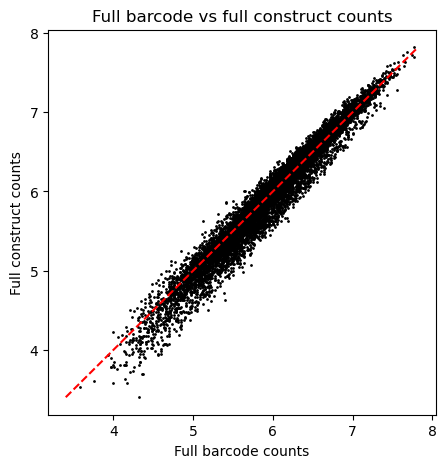

In [24]:
barcode_counts = complete_reads_df['full_bc'].value_counts()
construct_counts = complete_reads_df['full_construct'].value_counts()
plot_df = pd.DataFrame({'barcode_count': barcode_counts, 'construct_count': construct_counts})
plot_df = plot_df.dropna()
plt.figure(figsize=(5, 5))
plt.scatter(np.log(plot_df['barcode_count']), np.log(plot_df['construct_count']), c="black", s=1)
min_val = min(np.log(plot_df['barcode_count']).min(), np.log(plot_df['construct_count']).min())
max_val = max(np.log(plot_df['barcode_count']).max(), np.log(plot_df['construct_count']).max())
print(min_val, max_val)
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y')
plt.xlabel('Full barcode counts')
plt.ylabel('Full construct counts')
plt.title('Full barcode vs full construct counts')

In [98]:
# plot by correctness
def classify_construct_correctness(df):
    # check if the full barcode matches the full construct
    df["is_correct"] = df["full_bc"] == df["full_construct"]

    
    obs = df.groupby('full_bc').size().to_dict()
    cor = df.groupby('full_bc')['is_correct'].sum().to_dict()


    ratio_dict = {key: cor[key] / obs[key] for key in cor if key in obs}

    # length_dict_for_constructs = df.groupby('construct')['length'].first().to_dict()

    ratio_df = pd.DataFrame({
        'key': list(ratio_dict.keys()),
        'value': list(ratio_dict.values()),
        'obs': list(obs.values()),
        # 'length': [length_dict_for_constructs.get(key, 0) for key in ratio_dict]
    })
    
    return ratio_df

In [99]:
ratio_df = classify_construct_correctness(complete_reads_df)
ratio_df.head()

/tmp/ipykernel_3645/3656765139.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_correct"] = df["full_bc"] == df["full_construct"]


,key,value,obs
0,IRF2-EOMES-28zDAP10-BATF,0.619835,605
1,IRF2-EOMES-28zDAP10-CD59,0.616114,633
2,IRF2-EOMES-28zDAP10-CTLA4CD28,0.466667,360
3,IRF2-EOMES-28zDAP10-FOXO1,0.553398,103
4,IRF2-EOMES-28zDAP10-GFP,0.602614,765


In [100]:
# split by into ko, kd, gene, signaling based on '-' in the key using string split
# length of genes and length of signaling domains dictionaries
gene_lengths = {
    "IL2RA": 950,
    "IL7R": 1514,
    "LTBR": 1445,
    "CD59": 527,
    "TCF7L1": 1911,
    "Jun": 1146,
    "BATF": 512,
    "FOXO1": 2109,
    "IRF8": 1425,
    "GFP": 830,
    "mbaIL6": 1130,
    "Lgp130": 1276,
    "TGFBR2IL7RA": 2071,
    "CTLA4CD28": 837,
    "OX40": 978,
    "MYD88/CD40": 808,
}

signaling_lengths = {
    "CD28z": 794,
    "41BBz": 809,
    "ICOSz": 803,
    "TACI": 1014,
    "28zDAP10": 875,
    "CD28OX40CD3Z": 803,
    "CD40": 692,
    "LMP1LMP1LATCD3Z": 849,
    "FCRL6CD3G": 998,
    "delCD28z": 803,
}
constant_prefix_length = 1902
constant_suffix_length = 831

split_df = ratio_df['key'].str.split('-', expand=True)
split_df.columns = ['ko', 'kd', 'signaling', 'gene']
split_df["length"] = constant_prefix_length + split_df["gene"].map(gene_lengths) + split_df["signaling"].map(signaling_lengths) + constant_suffix_length
ratio_df["length"] = split_df["length"].astype(int)

In [101]:
ratio_df.head()

,key,value,obs,length
0,IRF2-EOMES-28zDAP10-BATF,0.619835,605,4120
1,IRF2-EOMES-28zDAP10-CD59,0.616114,633,4135
2,IRF2-EOMES-28zDAP10-CTLA4CD28,0.466667,360,4445
3,IRF2-EOMES-28zDAP10-FOXO1,0.553398,103,5717
4,IRF2-EOMES-28zDAP10-GFP,0.602614,765,4438


Text(0.5, 0, 'length')

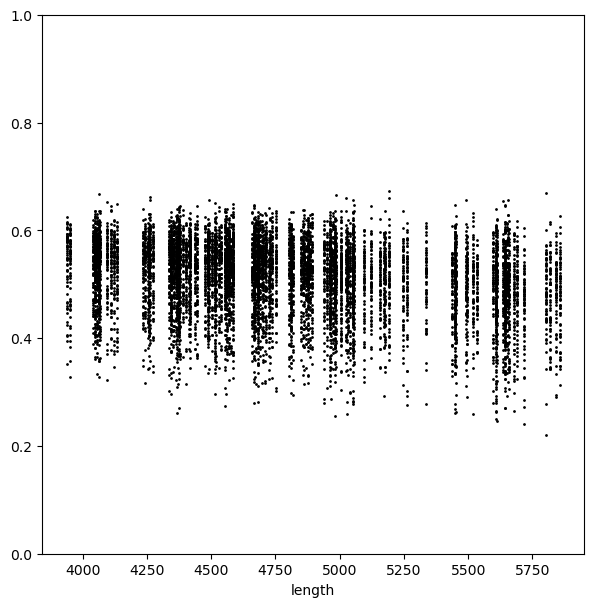

In [106]:
plt.figure(figsize=(7, 7))
plt.scatter(y=ratio_df.value, x=ratio_df.length, s=1, c="black")
plt.ylim(0, 1)
plt.xlabel("length")

Text(0.5, 0, 'log10(BC-counts)')

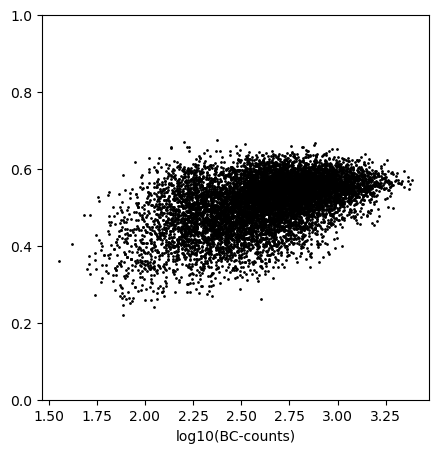

In [107]:
plt.figure(figsize=(5, 5))
plt.scatter(y=ratio_df.value, x=np.log10(ratio_df.obs), s=1, c="black")
plt.ylim(0, 1)
plt.xlabel("log10(BC-counts)")

In [ ]:
# plotted separately in python using ggpointdensity
ratio_df.to_csv("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/results/pLIB262_pacbio_ratio_df.csv", index=False)

In [ ]:
# summary bar plot
missing_gene = ((merged_df.gene.isna() & merged_df.gene_bc.isna()) & (merged_df[["ko", "ko_bc", "kd", "kd_bc", "signaling", "signaling_bc"]].isna().astype(int).sum(axis=1) == 0)).sum() / merged_df.shape[0]
missing_ko = ((merged_df.ko.isna() & merged_df.ko_bc.isna()) & (merged_df[["gene", "gene_bc", "kd", "kd_bc", "signaling", "signaling_bc"]].isna().astype(int).sum(axis=1) == 0)).sum() / merged_df.shape[0]
missing_kd = ((merged_df.kd.isna() & merged_df.kd_bc.isna()) & (merged_df[["ko", "ko_bc", "gene", "gene_bc", "signaling", "signaling_bc"]].isna().astype(int).sum(axis=1) == 0)).sum() / merged_df.shape[0]
missing_signaling = ((merged_df.signaling.isna() & merged_df.signaling_bc.isna()) & (merged_df[["ko", "ko_bc", "kd", "kd_bc", "gene", "gene_bc"]].isna().astype(int).sum(axis=1) == 0)).sum() / merged_df.shape[0]

print(missing_gene, missing_ko + missing_kd + missing_signaling)

0.12981440872968011 0.018239032066297733


In [129]:
# add some columns for calculation
merged_df["full_bc"] = merged_df["ko_bc"] + "-" + merged_df["kd_bc"] + "-" + merged_df["signaling_bc"] + "-" + merged_df["gene_bc"]
merged_df["full_construct"] = merged_df["ko"] + "-" + merged_df["kd"] + "-" + merged_df["signaling"] + "-" + merged_df["gene"]
merged_df["is_correct"] = merged_df.full_bc == merged_df.full_construct

# incorrect = 4-BC and 4-construct reads with a mismatch somewhere
incorrect = (merged_df.dropna().shape[0] - merged_df.is_correct.sum()) / merged_df.shape[0]

# fraction of reads which are correct
correct = merged_df.is_correct.sum() / merged_df.shape[0]

# missing a component
missing_something = (merged_df.shape[0] - merged_df.dropna().shape[0]) / merged_df.shape[0]

# compute single components missing
missing_gene = ((merged_df.gene.isna() | merged_df.gene_bc.isna()) & (merged_df[["ko", "ko_bc", "kd", "kd_bc", "signaling", "signaling_bc"]].isna().astype(int).sum(axis=1) == 0)).sum() / merged_df.shape[0]
missing_ko = ((merged_df.ko.isna() | merged_df.ko_bc.isna()) & (merged_df[["gene", "gene_bc", "kd", "kd_bc", "signaling", "signaling_bc"]].isna().astype(int).sum(axis=1) == 0)).sum() / merged_df.shape[0]
missing_kd = ((merged_df.kd.isna() | merged_df.kd_bc.isna()) & (merged_df[["ko", "ko_bc", "gene", "gene_bc", "signaling", "signaling_bc"]].isna().astype(int).sum(axis=1) == 0)).sum() / merged_df.shape[0]
missing_signaling = ((merged_df.signaling.isna() | merged_df.signaling_bc.isna()) & (merged_df[["ko", "ko_bc", "kd", "kd_bc", "gene", "gene_bc"]].isna().astype(int).sum(axis=1) == 0)).sum() / merged_df.shape[0]

# missing a single component
missing_single = ((merged_df.gene.isna() | merged_df.gene_bc.isna()) & (merged_df[["ko", "ko_bc", "kd", "kd_bc", "signaling", "signaling_bc"]].isna().astype(int).sum(axis=1) == 0)).sum() + \
    ((merged_df.ko.isna() | merged_df.ko_bc.isna()) & (merged_df[["gene", "gene_bc", "kd", "kd_bc", "signaling", "signaling_bc"]].isna().astype(int).sum(axis=1) == 0)).sum() + \
    ((merged_df.kd.isna() | merged_df.kd_bc.isna()) & (merged_df[["ko", "ko_bc", "gene", "gene_bc", "signaling", "signaling_bc"]].isna().astype(int).sum(axis=1) == 0)).sum() + \
    ((merged_df.signaling.isna() | merged_df.signaling_bc.isna()) & (merged_df[["ko", "ko_bc", "kd", "kd_bc", "gene", "gene_bc"]].isna().astype(int).sum(axis=1) == 0)).sum()
missing_single = missing_single / merged_df.shape[0]
missing_other = missing_something - missing_single

In [130]:
missing_other = missing_something - missing_single

print(f"Correct                {correct}")
print(f"Incorrect              {incorrect}")
print(f"Missing other:         {missing_other}")
print(f"Missing gene:          {missing_gene}")
print(f"Missing other single:  {missing_ko + missing_kd + missing_signaling}")

print(correct + incorrect + missing_other + missing_gene + missing_ko + missing_kd + missing_signaling)

Correct                0.25688991337874567
Incorrect              0.22513429605206794
Missing other:         0.17600212476109256
Missing gene:          0.2767319308222476
Missing other single:  0.06524173498584626
0.9999999999999999


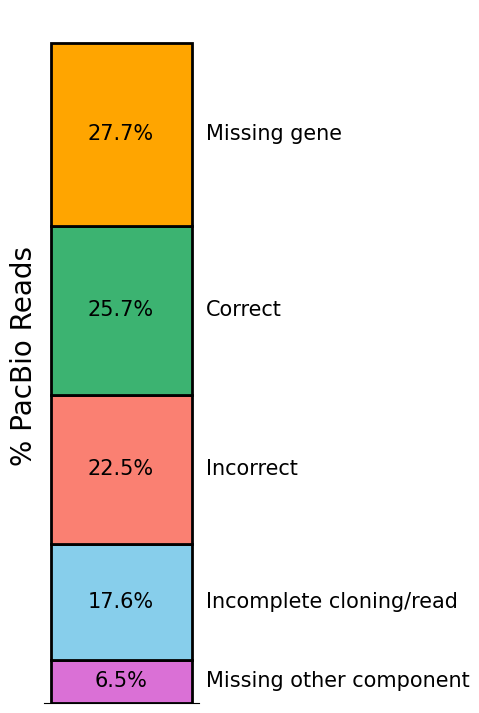

In [ ]:
d = {
    "Correct": correct, "Incorrect": incorrect, "Missing gene": missing_gene,
    "Missing other component": missing_ko+missing_kd+missing_signaling,
    "Incomplete cloning/read": missing_other
}
plot_df = pd.DataFrame.from_dict(d, orient='index', columns=['Value'])
plot_df["Name"] = plot_df.index

plot_df = plot_df.sort_values("Value").reset_index(drop=True)

fig, ax = plt.subplots(figsize=(2, 9))

bottom = 0
colors = ["orchid", "skyblue", "salmon", "mediumseagreen", "orange"]
for i, row in plot_df.iterrows():
    height = row["Value"]
    ax.bar(0, height, bottom=bottom, color=colors[i % len(colors)], edgecolor="black", linewidth=2)
    if height > 0.03:
        ax.text(0, bottom + height/2, f"{round(height*100, 1)}%", ha="center", va="center", size=15)
    ax.text(0.48, bottom + height/2, f"{row["Name"]}", ha="left", va="center", size=15)


    bottom += height

plt.xlabel("")
plt.ylabel("% PacBio Reads", size=20)
plt.title("")
plt.xticks([], [])
plt.yticks([], [])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()